In [140]:
import sys
print(sys.version)

3.6.5 (default, Apr  1 2018, 05:46:30) 
[GCC 7.3.0]


In [1]:


import madmom
import numpy as np
import madmom.audio.cepstrogram
from madmom.audio.filters import MelFilterbank
from madmom.audio.filters import RectangularFilterbank
from sklearn.decomposition import PCA, FastICA, NMF
import matplotlib.pyplot as plt
import librosa
import pyaudio
import time
import scipy

FRAME_SIZE=2**11
HOP_SIZE=2**9
SAMPLE_RATE=44100
FREQUENCY_PRE=np.ones((24))#[0,16384]#0-2^14
MIDINOTE=36 #kickdrum in most systems
THRESHOLD=0.0 
PROBABILITY_THRESHOLD=0.0
DRUMKIT_PATH='./oikeetsamplet/'
midinotes=[36,38,42,46,50,43,51,49,44] #BD, SN, CHH, OHH, TT, FT, RD, CR, SHH

proc=madmom.audio.filters.BarkFilterbank(madmom.audio.stft.fft_frequencies(num_fft_bins=int(FRAME_SIZE/2), sample_rate=SAMPLE_RATE) ,num_bands='double')
#proc=madmom.audio.filters.LogarithmicFilterbank(num_bands=24)
class Drum(object):
    """
    A Drum is any user playable drumkit part representation

    Parameters
    ----------
    name : String
        Name of the drum
    frequency_pre : list, optional
        corner frequencies of drum signal
    midinote: int, optional
        midi note representing the drum
    threshold : float, optional
        onset detection threshold.
    probability_threshold : float, optional
        NN prediction threshold.
    

    Notes
    -----
    Unfinished class, work in progress

    """
    def __init__(self, name,highEmph,peaks, samples=None,templates=None, frequency_pre=FREQUENCY_PRE,
                 midinote=MIDINOTE, threshold=THRESHOLD, probability_threshold=PROBABILITY_THRESHOLD
                 ,**kwargs):
        
        # set attributes
        self.name = name
        self.highEmph=highEmph
        self.peaks=peaks
        if len(frequency_pre):
            self.frequency_pre = frequency_pre
        if len(samples):
            self.samples = samples
        if len(templates):
            self.templates=templates
        if midinote:
            self.midinote=midinote
        if threshold:
            self.threshold = float(threshold)
        if probability_threshold:
            self.probability_threshold=float(probability_threshold)
    def set_name(self,name):
        self.name=name
    def get_name(self):
        return self.name
    def set_highEmph(self,highEmph):
        self.highEmph=highEmph
    def get_highEmph(self):
        return self.highEmph
    def set_peaks(self,name):
        self.name=peaks
    def get_peaks(self):
        return self.peaks
    def set_templates(self,templates):
        self.templates=templates
    def get_templates(self):
        return self.templates 
    def set_samples(self,samples):
        self.samples=samples
    def get_samples(self):
        return self.samples
    def set_frequency_pre(self,frequency_pre):
        self.frequency_pre=frequency_pre
    def get_frequency_pre(self):
        return self.frequency_pre  
    def set_midinote(self,midinote):
        self.midinote=int(midinote)
    def get_midinote(self):
        return self.midinote
    def set_threshold(self,threshold):
        self.threshold=float(threshold)
    def get_threshold(self):
        return self.threshold
    def set_probability_threshold(self,probability_threshold):
        self.probability_threshold=float(probability_threshold)
    def get_probability_threshold(self):
        return self.probability_threshold

#live audio
print('noniin')

#From https://stackoverflow.com/questions/24354279/python-spectral-centroid-for-a-wav-file
def spectral_centroid(x, samplerate=44100):
    magnitudes = np.abs(np.fft.rfft(x)) # magnitudes of positive frequencies
    length = len(x)
    freqs = np.abs(np.fft.fftfreq(length, 1.0/samplerate)[:length//2+1]) # positive frequencies
    return np.log(np.sum(magnitudes*freqs) / np.sum(magnitudes))
def ZCR(signal):
    ZC=0
    for i in range(1,signal.shape[0]):
        if np.sign(signal[i-1])!=np.sign(signal[i]):
            ZC+=1
    return ZC
#brickwall limiter to even out high peaks
def limitToPercentile(data, limit=90, lowlimit=10, ratio=1):
    limit=np.percentile(data,limit)
    lowlimit=np.percentile(data,lowlimit)
    highPeaks = abs(data) > limit # Where values higher than the percentile
    data[highPeaks] = limit #brickwall the signal to the limit
    lowPeaks = abs(data) < lowlimit # Where values higher than the percentile
    data[lowPeaks] = np.sign(data[lowPeaks])*lowlimit #brickwall the signal to the limit
    return (data)
def cleanDoubleStrokes(hitList, resolution=10):
        retList=[]
        lastSeenHit=0
        for i in range(len(hitList)):
            if hitList[i]>=lastSeenHit+resolution:
                retList.append(hitList[i])
                lastSeenHit=hitList[i]
        return (np.array(retList))
##Pitäiskö laittaa toi gäppi kans määriteltäväksi??    
def filter_emphasis(spectro,highEmph):
    #Otetaan hetkeksi pois käytöstä
    return spectro
    dummy=np.zeros_like(spectro)

    if(highEmph==-1):
        dummy[:,:5]=spectro[:,:5]
    elif(highEmph==0):
        dummy[:,2:7]=spectro[:,2:7]
    elif(highEmph==1):
        dummy[:,-5:]=spectro[:,-5:]
    elif(highEmph==2):
        dummy=spectro
        
    return dummy

def muLaw(Y, mu=10**8):
    #n=frames, i=sub-bands
    x_mu=np.zeros_like(Y)

    for n in range(Y.shape[0]):
        for i in range(Y.shape[1]):
            #x_i_n=Y[n,i].flatten()@Y[n,i].flatten()
            x_i_n=Y[n,i]
            x_mu[n,i]= np.sign(Y[n,i]) * np.log(1 + mu * x_i_n)/np.log(1 + mu)
    return x_mu

def get_preprocessed_spectrogram(buffer):
    buffer=buffer/max(buffer)
    buffer=madmom.audio.FramedSignal(buffer,sample_rate=SAMPLE_RATE,frame_size=FRAME_SIZE, hop_size=HOP_SIZE)
    spec=madmom.audio.spectrogram.FilteredSpectrogram(buffer, filterbank=proc, sample_rate=SAMPLE_RATE,frame_size=FRAME_SIZE, hop_size=HOP_SIZE, fmin=20)
    #spec=muLaw(spec,mu=10**8)
    spec=spec/spec.max()
    return spec

#Too hard coded method- refine generality
def generate_features(signal, highEmph):
    features=[]
    try:    
        #fiba=madmom.audio.spectrogram.FilteredSpectrogram(signal,filterbank=proc,sample_rate=44100, f_min=10)
        fiba=get_preprocessed_spectrogram(signal)
        fiba2=filter_emphasis(fiba, highEmph)
        mfcc2=madmom.audio.cepstrogram.MFCC(fiba2, num_bands=32)
        mfcc_delta = librosa.feature.delta(mfcc2)
        mfcc_delta2 = librosa.feature.delta(mfcc2, order=2)

        feats=np.append(mfcc2[0],[mfcc2[1]
                                  ,mfcc2[2]
                                  ,mfcc2[3]
                                  , mfcc_delta[0]
                                  , mfcc_delta[1]])
        features=(np.append(feats,[np.append([ZCR(signal)]
                                                   , [np.append([scipy.stats.kurtosis(signal)]
                                                        ,[np.append([scipy.stats.skew(signal)]
                                                            ,[spectral_centroid(signal)])])])])) 
        
    except Exception as e:
        print('feature error:',e)
        """muista panna paddia alkuun ja loppuun""" 
        
    return features
def make_sample(signal, time, n_frames):
    sample=madmom.audio.signal.signal_frame(signal,time, frame_size=n_frames*HOP_SIZE, hop_size=HOP_SIZE, origin=0)
    sample=madmom.audio.signal.normalize(sample)
    return sample

def add_to_samples_and_dictionary(drum, signal, times):
    for i in times:
        sample=make_sample(signal, i,n_frames=4)
        drum.get_samples().append(sample)
        drum.get_templates().append(generate_features(sample, drum.get_highEmph()))
        
def getPeaksFromBuffer(buffer, resolution, numHits, highEmph=0):
    
    filt_spec=get_preprocessed_spectrogram(buffer)
    
    def findDefBins(frames, filteredSpec):
        gaps=np.zeros(frames.shape[0]*10)
        tailgaps=np.zeros(frames.shape[0]*10)
        n_frames=4
        for i in range(frames.shape[0]):
            
            gaps[(i*n_frames)]=frames[i]
            gaps[(i*n_frames)+1]=frames[i]+1
            gaps[(i*n_frames)+2]=frames[i]+2
            

        heads=np.mean(filteredSpec[gaps.astype(int)].T, axis=1)
        tailgaps=np.ones(filteredSpec.shape[0])
        tailgaps[gaps.astype(int)]=0
        tails=(np.mean(filteredSpec[tailgaps==1].T, axis=1))
        #tails=(np.mean(filteredSpec[tailgaps.astype(int)].T, axis=1))
        return(heads, tails)
        #heads=np.mean(filteredSpec.T, axis=1)
        #return(heads, tails)
        #return(np.mean(filteredSpec[gaps.astype(int)].T, axis=1),np.mean(filteredSpec[-gaps.astype(int)].T, axis=1))
    
    superflux_3 = madmom.features.onsets.superflux(filt_spec)
    superflux_3=superflux_3/(superflux_3.max(axis=0) )
    
    threshold=1
    searchSpeed=0.2
    peaks=cleanDoubleStrokes(madmom.features.onsets.peak_picking(superflux_3,threshold),resolution)
    
    while(peaks.shape!=(numHits,)):
        #Make sure we don't go over numHits
        #There is a chance of an infinite loop here!!! Make sure that don't happen
        if(peaks.shape[0]>numHits):
            threshold+=searchSpeed
            searchSpeed=searchSpeed/2
        threshold-=searchSpeed
        peaks=cleanDoubleStrokes(madmom.features.onsets.peak_picking(superflux_3,threshold),resolution)

    definingBins=findDefBins(peaks,filt_spec)
    return peaks, definingBins, threshold
    #return peaks, np.zeros(24), threshold
    
def playSample(data):
    # instantiate PyAudio (1)
    p = pyaudio.PyAudio()
    # open stream (2)
    stream = p.open(format=pyaudio.paFloat32,
                    frames_per_buffer=HOP_SIZE,
                    channels=1,
                    rate=44100,
                    output=True)
    # play stream (3)
    f=0
    print(len(data))
    while data!='':
        stream.write(data[f])
        f+=1
        if f>=len(data):
            break

    # stop stream (4)
    stream.stop_stream()
    stream.close()
    
    # close PyAudio (5)
    p.terminate()

def getStompTemplate(numHits=2, recordingLength=1, highEmph=0):
    """
    Kutsutaan pari kertaa, eka vaikka kaks ja sit neljä iskua talteen
    Niiden pohjalta lasketaan olennaisin taajuus ja threshold
    """
    stompResolution=1
    buffer=np.zeros(shape=(227792*recordingLength))
    j=0
    strm=madmom.audio.signal.Stream(sample_rate=44100, num_channels=1,frame_size=2048, hop_size=HOP_SIZE)
    for i in strm:
            #print(i.shape)
            buffer[j:j+HOP_SIZE]=i[:HOP_SIZE]
            j+=HOP_SIZE
            if j>=221792*recordingLength:
                buffer[j:j+6000]=np.zeros(6000)
                #buffer=madmom.audio.signal.normalize(buffer)
                peaks, bins, threshold=getPeaksFromBuffer(buffer, stompResolution,numHits, highEmph=highEmph) 
                
                strm.close()
                return peaks, bins,threshold, buffer
            

"""Jotain tähän tyyliin sitten sämplejä talteen"""
nrOfDrums=9
nrOfPeaks=32
fpr=np.zeros((proc.shape[1], nrOfDrums*2))
#frames=np.zeros((8192,nrOfDrums*nrOfPeaks))
drums=[]
list_X=[]
list_y=[]
#NoneTemplates=[]
highEmph=[0,0,0,1,0,0,1,1,0]
#highEmph=[2,2,2,2,2,2,2,2,2]
###Tässä pitää napata talteen framet/sample
for i in range(nrOfDrums):
    try:
        soundcheck=False
        print("{}drum{}.wav".format(DRUMKIT_PATH,i))
        buffer=madmom.audio.Signal("{}drum{}.wav".format(DRUMKIT_PATH,i),frame_size=2048, hop_size=HOP_SIZE)
        CC1, freqtemps, threshold=getPeaksFromBuffer(buffer,1,nrOfPeaks,highEmph=highEmph[i])
        fpr[:,i]=freqtemps[0]
        fpr[:,i+nrOfDrums]=freqtemps[1]
    except Exception as e: 
        print(e)
        print('samples not found, please soundcheck!')
        print("Play drum nr. {}".format(i+1))
        CC1, freqtemps, threshold, buffer= getStompTemplate(nrOfPeaks,recordingLength=2,highEmph=highEmph[i]) 
        #outBuffer=unFrameSignal(buffer)
        madmom.io.audio.write_wave_file(buffer, './drum{}.wav'.format(i),sample_rate=44100)
        
    if(True):
        templates=[]
        samples=[]
        
        
        
        for j in range(len(CC1)):
            
            time=CC1[j]
            
            tinyBuff=make_sample(buffer, time, n_frames=4)
            templates.append(generate_features(tinyBuff, highEmph[i]))
        
            samples.append(tinyBuff)
            
        drums.append(Drum(name=[i], highEmph=highEmph[i], peaks=CC1,templates=templates, samples=samples, threshold=threshold, midinote=midinotes[i], probability_threshold=1))

'''generate artificial samples where multiple drums are hit at the same time, store as Drum objects'''

def generateNewSample(drums):
    samplesA=drums[0].get_samples()
    samplesB=drums[1].get_samples()
    samplesC=[]
    for i in range(min([len(samplesA), len(samplesB)])):
        samplesC.append((.5*samplesA[i])+(.5*samplesB[i]))
    samplesC=np.array(samplesC)
  
    templatesC=[]
    highEmphA=drums[0].get_highEmph()
    highEmphB=drums[1].get_highEmph()
    if highEmphA==highEmphB:
        for j in range(len(samplesC)):
            templatesC.append(generate_features(samplesC[j], highEmph))
            
    #Jos ei highemph täsmää tehdään puolet toista ja puolet toista.        
    else:
        for j in range(int(len(samplesC)/2)):
            templatesC.append(generate_features(samplesC[j], highEmphA))
            templatesC.append(generate_features(samplesC[-j], highEmphB))
            
    return Drum([drums[0].get_name(),drums[1].get_name()],0, None,templates=templatesC, samples=[], midinote=[])  

from itertools import combinations, permutations
newDrums=combinations(drums[:nrOfDrums], 2)
for i in newDrums:
    drums.append(generateNewSample(i))
    
#try:
#        
#    soundcheck=False
#    buffer=madmom.audio.Signal("{}drumBeat.wav".format(DRUMKIT_PATH),frame_size=2048, hop_size=HOP_SIZE)
#    
#except:
#    print('samples not found, please soundcheck!')
#    print("Play a drum beat")
#    CC1, frequencies, threshold, buffer= getStompTemplate(nrOfPeaks,recordingLength=4,highEmph=-1) 
#    madmom.io.audio.write_wave_file(buffer, '{}drumBeat.wav'.format(DRUMKIT_PATH),sample_rate=44100)
#    print('joo joo, voit lopettaa jo')
#
    
### tee list_X ja list_y täsä drumseista.

for i in drums:
    #one for every template the drum has stored
    for j in i.get_templates():
        #one for every drum present in the template
        a=np.ravel(i.get_name())
        for k in range(len(a)):
            list_X.append(j)
            list_y.append(a[k])




##Classify all the templates so that precision is 1, and set the PROBABILITY_THRESHOLD accordingly.

'''Tänne generator NN keras, joka oppii sitä mukaa ku roinaa tulee'''
'''Eka opetellaan haitsun poljenta joka toimii käyttöliittymän osana'''
'''Sit eri rummut'''
'''Sit aletaan skabaamaan ja soittajan pätkät analysoidaan, muutetaan midiksi ja niistä sit opitaan generoimaan uutta'''

#Tää jäi siihen että sai jotenkuten sn,bd,hh eroamaan, mutta jotain mätää on filttereissä kun basari ja snare on melkein samaa aaltoa.

noniin
./oikeetsamplet/drum0.wav


/Users/mikkelbom/anaconda/lib/python3.5/site-packages/madmom-0.16.dev0-py3.5-macosx-10.6-x86_64.egg/madmom/audio/cepstrogram.py:202: UserWarning: Spectrogram was filtered or scaled already, redo calculation!
  warnings.warn('Spectrogram was filtered or scaled already, redo '


./oikeetsamplet/drum1.wav
./oikeetsamplet/drum2.wav
./oikeetsamplet/drum3.wav
./oikeetsamplet/drum4.wav
./oikeetsamplet/drum5.wav
./oikeetsamplet/drum6.wav
./oikeetsamplet/drum7.wav
./oikeetsamplet/drum8.wav


'Sit aletaan skabaamaan ja soittajan pätkät analysoidaan, muutetaan midiksi ja niistä sit opitaan generoimaan uutta'

In [2]:
import keras
from keras.models import Sequential
from keras import backend as K
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.optimizers import sgd as SGD
#from keras.layers.advanced_activations import ELU
#from keras.utils import np_utils
from keras.layers import Convolution2D, Convolution1D, GRU, LSTM,BatchNormalization
#from keras.layers import MaxPooling2D, MaxPooling1D, AveragePooling2D
#from keras.layers import Flatten, Input
#import pandas as pd
import numpy as np
#import librosa as lb
#from os import listdir
#import lightgbm as lgb
#import pickle
from sklearn.utils import resample
from sklearn import preprocessing
from time import time

n_samples=2**14


X,y=resample(np.array(list_X),np.array(list_y), n_samples=n_samples)

scaler=preprocessing.MinMaxScaler()
X_train=scaler.fit_transform(X)

y_train=y

y_train=keras.utils.np_utils.to_categorical(y_train)

print(X_train.shape)
print(y_train.shape)
num_labels = y_train.shape[1]
model = Sequential()
model.add(Dense(196, input_shape=(X_train.shape[1],), init='he_normal'))
model.add(Dropout(0.7))
model.add(BatchNormalization())
model.add(Dense((98), init='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dense(49, init='lecun_uniform', activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_labels, init='lecun_uniform', activation="softmax"))
print(model.summary())

t0=time()
modelsaver=ModelCheckpoint(filepath="weights_testivedot.hdf5", verbose=1, save_best_only=True)
earlystopper=EarlyStopping(monitor="val_loss", patience=20, mode='auto')
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='nadam')
model.fit(X_train, y_train,batch_size=1024, nb_epoch=100
          , callbacks=[modelsaver,earlystopper]
          ,validation_split=0.1
          ,verbose=2)
model.load_weights("weights_testivedot.hdf5")
print("Loaded model from disk")
model.save('keras.model_testivedot.h5')
cnn=model
print('Model saved to disk.')
print ('Model buiding time:%0.2f' %(time()-t0))
t0=time()



Using Theano backend.


(16384, 196)
(16384, 9)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 196)           38612       dense_input_1[0][0]              
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 196)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormal(None, 196)           392         dropout_1[0][0]                  
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 98)            19306       batchnormalization_1[0][0]       
___________________________________________________________________

In [9]:
%matplotlib notebook
from madmom.audio.filters import RectangularFilterbank
from scipy.ndimage.filters import maximum_filter, median_filter
import pandas as pd
import madmom
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
import lightgbm as lgb
from  collections import defaultdict as dd
from time import time
t0=time()
#drums=drums[:nrOfDrums]

#Tämä on vähän turha luokka, kaiken voi tallettaa drum objektiin
class detector(object):
    def __init__(self, drum,hitlist=None
                 ,**kwargs):
        # set attributes
        self.drum = drum
        if hitlist:
            self.hitlist = hitlist   
        else:
            self.hitlist=None
    def set_hits(self,hitlist):
        self.hitlist=hitlist
    def get_hits(self):
        return self.hitlist
    def get_name(self):
        return self.drum.get_name()
    def get_midinote(self):
        return self.drum.get_midinote()
    def get_threshold(self):
        return self.drum.get_threshold()
    def get_frequency_pre(self):
        return self.drum.get_frequency_pre()
    def get_probability_threshold(self):
        return self.drum.get_probability_threshold()
    
peakList=[]
for i in drums[:nrOfDrums]:
    peakList.append(detector(i, hitlist=None))

if 'cnn' not in globals():
    from keras.models import load_model
    cnn = load_model('./keras.model_testivedot.h5')
    cnn.load_weights("./weights_testivedot.hdf5")
    
#From https://stackoverflow.com/questions/1566936/
class prettyfloat(float):
    def __repr__(self):
        return "%0.3f" % self

#superlux from madmom (Böck et al)
def superflux(A,B):
    kernel=np.hamming(8)
    from scipy.signal import convolve
    B=convolve(B, kernel, 'same')
    B=B/max(B)
    spec_x=np.outer(A,B)
    diff = np.zeros_like(spec_x.T)
    size = (2,16)
    max_spec = maximum_filter(spec_x.T, size=size)
    diff[1:] = (spec_x.T[1:] - max_spec[: -1])
    pos_diff = np.maximum(0, diff)
    sf = np.sum(pos_diff, axis=1)
    sf=sf/max(sf)
    return sf

def frame_to_time(frames, sr=44100, hop_length=HOP_SIZE, hops_per_frame=1):
    samples= (np.asanyarray(frames) * (hop_length/hops_per_frame)).astype(int)
    return np.asanyarray(samples) / float(sr)   
def time_to_frame(times, sr=44100, hop_length=HOP_SIZE, hops_per_frame=1):
    samples= (np.asanyarray(times) *float(sr))
    return (np.asanyarray(samples)/ (hop_length/hops_per_frame)).astype(int)
    

def f_score(hits, hitNMiss, actual):
        try:
            precision=(float(hits)/hitNMiss)
            recall=(float(hits)/actual)
            fscore=(2*((precision*recall)/(precision+recall)))
            return (precision, recall, fscore)
        except Exception as e:
            print (e)
            return (0.0,0.0,0.0)
def k_in_n(k,n, window=1):
    hits=0
    for i in n:
            for j in k:    
                if (j-window <= i <= j+window): 
                    hits+=1
                    break
                if(j+window>i):
                    break
    return float(hits)

MS_IN_MIN=60000
SXTH_DIV=8
#Create a mask of 16th notes for the duration of the drumtake based on the tempomap
def tempoMask(tempos):
    #Move all tempos to half-notes to counter erratic behaviour when tempo extraction doubles tempo value.
    for i in range(tempos.size):
        if tempos[i]>100:
            while tempos[i]>100:
                tempos[i]=tempos[i]/2
    #define the length of a sixteenthnote in ms in relation to tempo at time t
    sixtLength=MS_IN_MIN/tempos/SXTH_DIV
    #define the length of a frame in ms
    frameLength=1000*HOP_SIZE / SAMPLE_RATE
    #extract indices in X that correspond to a 16th note in tempo at time t
    #by calculating modulo and taking the inverse boolean array mod(a,b)==0 ==True
    indices=np.array([int((s%(sixtLength[s]/frameLength))) for s in range(0,tempos.shape[0])])
    invertedIndices=np.invert(indices.astype('bool'))
    return invertedIndices

#Quantize hits accordng to 16th Note mask
def quantize(X, mask, strength=1, tempo=128, conform=False):
    #Create a mask of constant tempo
    if conform:
        #drop less than 100 to half 
        if tempo<100:
            tempo=tempo/2
        conformMask=tempoMask(np.full(mask.size*2, tempo))
        trueInd=np.where(mask==True)[0]
        dim=min(np.where(conformMask==True)[0].size,trueInd.size )
        cMask=np.where(conformMask==True)[0][:dim]-trueInd[:dim]
        shiftMask=mask.astype(int)
        n=0
        for i in trueInd:
            shiftMask[i]=cMask[n]
            n+=1
    #iterate found onsets
    retX=np.zeros_like(X)
    n=0
    for i in X:
        k=0
        notfound=True
        
        #shift 
        j=0
        
        #set limit to shift
        jLim=min(i, mask.size-i)
        while notfound:
            
            #If the shift is at either end of the mask remove onset
            if j==jLim:
                notfound=False
                k=None
                
            #If the onset is in 16th note mask
            if mask[i]==True:
                notfound=False
                k=i
                if conform:
                    k+=shiftMask[i]
                
            #Move the onset forvard by j frames and compare,
            #if 16th note found in the mask move the onset there
            elif mask[i+j]==True:
                notfound=False
                k=i+j
                if conform:
                    k+=shiftMask[i+j]
                
            #backward move of the onset
            elif mask[i-j]==True:
                notfound=False
                k=i-j
                if conform:
                    k+=shiftMask[i-j]
                
            #increase shift
            j+=1
        #Store the quantized value to return list    
        retX[n]=int((k*strength+i*(1-strength)))
        #increase return list index
        n+=1
        #Tähän sitten tästä gridistä tempoon...
    return retX[retX != np.array(None)]
def get_cmask(tempo, tempomask):
    
    return cMask

def semi_adaptive_NMFB(X,Wpre,n_iterations=100, alternate=False, adaptive=False, leeseung=False, div=1, sp=0):
    if alternate==True:
        n_iterations=n_iterations*2
    [numRows,numCols] = X.shape
    epsilon=10**-16
    X = X + epsilon
    W = Wpre
    H = np.ones((W.shape[1],numCols))
    H=abs(np.random.normal(0,0.5,[W.shape[1],numCols]))
    err=np.zeros(n_iterations)
    sparsity=sp
    for i in range(W.shape[1]):
        normB = np.linalg.norm(W[:,i], ord=np.inf)
        W[:,i] = W[:,i]/normB
    Wt = W.T
    def KLDiv(x,y):
        return sum(sum(x*np.log(x/y)+(y-x)))
    def ISDiv(x,y):
        return sum(sum((x/y)-np.log(x/y)-1))
    def BRDiv(x,y):
        return sum(sum((( 1 / (div * (div-1) )) * ( x**div + (div-1) * y**div -div * x * y**(div-1) ))))
    def LS(x,y):
        return sum(sum((x-y)**2))
    WH = epsilon+np.dot(W,H)
    for i in range(n_iterations):
        
        #Algorithm according to "Battenberg et al. Live Drum Separation Using Probabilistic Spectral Clustering"
        if leeseung=='bat':
            Himin=H
            H = H*(Wt@(X*WH**(div-2)))/(epsilon+(Wt@WH**(div-1))+sparsity)
            Ht = H.T
        WH = epsilon+np.dot(W,H)    
        normH = np.linalg.norm(H, ord=np.inf)
        #IS-divergence
        if div==0:
            err[i]=ISDiv(X,WH)+(sparsity*normH)
        #KL-divergence
        elif div==1:
            err[i]=KLDiv(X,WH)+(sparsity*normH)
        #EUC-distance
        elif div == 2:
            err[i]=LS(X,WH)+(sparsity*normH)
        # Bregman-divergence
        else:
            err[i]=BRDiv(X,WH)+(sparsity*normH)
        sparsity=1/err[i]
        if (i>=2) :              
            if (abs(err[i] - err[i-1]) / (err[1] - err[i])+epsilon) < 0.0001:
                break    
    Xpost=np.zeros((W.shape[1],numRows, numCols))
    for i in range(int(W.shape[1])):
        Xpost[i] = np.outer(W[:,i],H[i,:])
    return Xpost, W, H


##This removes the effect of reverb/echo. i.e. peak min resolution 20 frames
def cleanDoubleStrokes(hitList, resolution=10):
    if len(hitList)==0:
        return hitList
    hitList.sort()
    retList=[]
    lastSeenHit=-1*resolution
    adjacents=[]
    for i in hitList:
        if len(adjacents)>=1:
            if i>=np.min(adjacents)+resolution:
                retList.append(np.min(adjacents))
                lastSeenHit=np.min(adjacents)
                adjacents=[]
                
        adjacents.append(i)
    #add last hit to the list
    retList.append(np.min(adjacents))
    return (np.array(retList))



#brickwall limiter to even out high peaks
def limitToPercentile(data, limit=99.9, lowlimit=0, ratio=1):
    limit=np.percentile(data,limit)
    lowlimit=np.percentile(data,lowlimit)
    highPeaks = abs(data) > limit # Where values higher than the percentile
    data[highPeaks] = limit #brickwall the signal to the limit
    lowPeaks = abs(data) < lowlimit # Where values higher than the percentile
    data[lowPeaks] = 0 #brickwall the signal to the limit
    return (data/max(data))
def pruneCNN(foundhits, label, booster, thresh, buffer):
        if booster==None:
            return foundhits
        v_X=[]
        templates=[]
        if foundhits.size==0:
            return foundhits
        for row in foundhits:
            time=row
            try:  
                tinyBuff=make_sample(buffer, time, n_frames=4)                
                v_X.append(generate_features(tinyBuff, peakList[label[0]].drum.get_highEmph()))
            except:
                """muista panna paddia alkuun ja loppuun""" 
        from sklearn import preprocessing
        scaler=preprocessing.MinMaxScaler()
        v_X=scaler.fit_transform(np.array(v_X))
        preds_CNN=booster.predict(v_X)
        remove=[]
        for i in range(len(preds_CNN)):
            preds_CNN[i]=preds_CNN[i]/preds_CNN[i].max()
            #topThree=preds_CNN[i].argsort()[-3:][::-1]
            ##print (topThree)
            #if label not in topThree:
            #    if isSoundcheck<0:
            #        remove.append(i)
            #if np.argmin(preds_CNN[i])==label:
            #    if isSoundcheck<0:
            #        remove.append(i)
            if (preds_CNN[i][label])<thresh:
                remove.append(i)
            ##OHH over CHH
            #if label[0]==2 and preds_CNN[i][label]<=preds_CNN[i][3]:
            #    if isSoundcheck<0:         
            #        remove.append(i)
            #CHH over OHH
            #if label[0]==3 and preds_CNN[i][label]<=preds_CNN[i][2]:
            #    if isSoundcheck<0:
            #        remove.append(i)
            ##OHH over Ride
            #if label[0]==6 and preds_CNN[i][label]<=preds_CNN[i][3]:
            #    if isSoundcheck<0:
            #        remove.append(i)
            ###CHH over HHStomp
            #if label[0]==8 and  preds_CNN[i][label]<=preds_CNN[i][2]:
            #    if isSoundcheck<0:
            #        remove.append(i)    
        return np.delete(foundhits, remove)
#aloita ikkuna x[:-window]
def movingAverage(x,window=500):
        return median_filter(x, size=(window))
    
def processLiveAudio(liveBuffer=None, booster=cnn, classifier='LGB', basis=None, quant_factor=0.0):

    
    filt_spec=get_preprocessed_spectrogram(liveBuffer)

    Xpost, W, H = semi_adaptive_NMFB(filt_spec.T,basis,n_iterations=2000,
                                     alternate=False, adaptive=False, leeseung='bat', div=0, sp=2)
    bdTempo=(librosa.beat.tempo(onset_envelope=np.sum(H, axis=0), sr=SAMPLE_RATE,hop_length=HOP_SIZE,ac_size=8, aggregate=None))
    bdAvg=movingAverage(bdTempo, window=1200)
    #print(bdAvg.shape)    
    #snTempo=(librosa.beat.tempo( onset_envelope=H[1], sr=SAMPLE_RATE,hop_length=HOP_SIZE))
    #plt.figure()
    ##plt.plot(movingAverage(snTempo, 0,bdTempo.shape))
    #plt.plot(bdTempo, color='r')
    #plt.plot(bdAvg, color='g')
    #print(np.mean(bdTempo))
    #print(np.mean(bdAvg))
    #win=2000
    #plt.plot(librosa.beat.tempo(onset_envelope=H[0], sr=SAMPLE_RATE,hop_length=HOP_SIZE
    #                             , aggregate=movingAverage), color='b')
    tempomask=tempoMask(bdAvg)

    for i in peakList:
        
        H0=superflux(W[i.get_name()].T[0],H[i.get_name()][0])
        peaks=madmom.features.onsets.peak_picking(H0 ,i.get_threshold(),
                                                smooth=None, pre_avg=0, post_avg=0,pre_max=1, post_max=1)
        TEMPO=120
        qPeaks=quantize(peaks, tempomask, strength=quant_factor, tempo=TEMPO, conform=True)
        
        #cPeaks=conformToTempo(qPeaks, tempo, tempomask)
        
        #print((peaks, qPeaks))
        peakList[i.get_name()[0]].set_hits(qPeaks)

    duplicateResolution=0.01

    for i in peakList:
        precHits=frame_to_time(i.get_hits())
        i.set_hits(time_to_frame(cleanDoubleStrokes(precHits, resolution=duplicateResolution)))
   
    #prune onsets with CNN classifier
    if (classifier=='CNN'):

        for i in peakList:
            prob_thresh=i.get_probability_threshold()
            i.set_hits(pruneCNN(i.get_hits(),i.get_name(), cnn,prob_thresh, liveBuffer))

    
    return peakList


if 'cnn' not in globals():
    from keras.models import load_model
    cnn = load_model('./keras.model_testivedot.h5')
souncheck=False

if souncheck==True:
    
    print('reset all thresholds:')
    for i in range(nrOfDrums):
        drums[i].set_probability_threshold(0.01)
        drums[i].set_threshold(0.)
    print('done')
    comp_buffer=np.zeros(0)
    for i in range(nrOfDrums):
        try:
            buffer=(madmom.audio.Signal("{}drum{}.wav".format(DRUMKIT_PATH,i),sample_rate=SAMPLE_RATE, frame_size=2048, hop_size=HOP_SIZE))
            new_buffer=np.zeros(comp_buffer.shape[0]+buffer.shape[0])
            new_buffer[:comp_buffer.shape[0]]=comp_buffer
            new_buffer[comp_buffer.shape[0]:]=buffer
            comp_buffer=new_buffer
            
        except Exception as e:
            print (e)
            print('jotain meni vikaan!')
    drumtake_frame_count=buffer.shape[0]/HOP_SIZE
    filt_spec=get_preprocessed_spectrogram(comp_buffer)
    
    Xpost, W, H = semi_adaptive_NMFB(filt_spec.T,fpr,n_iterations=2000, alternate=False, adaptive=False, leeseung='bat', div=0, sp=1.5)
    
    
#############################ISTFT###########################
    from scipy.signal import istft
    print(Xpost[0].shape)
    for i in range(nrOfDrums):
        wav=librosa.core.istft(filt_spec.T, hop_length=441, window='hann',
          center=True, dtype=np.float32, length=None)
        madmom.io.audio.write_wave_file(wav, './drum{}.wav'.format(i),sample_rate=SAMPLE_RATE)
    
    
        
    totalF, totalP, totalR=0,0,0
    for i in range(nrOfDrums):
        searchSpeed=0.05
        found=0
        n=np.array(0)
        fscore,fscore_old=0.,0.
        prec, prec_old=0.,0.
        rec, rec_old=1.,1.
        #kernel = np.kaiser(7,5)
        H0=superflux(W.T[i],H[i])
        #H0=H[i]/H[i].max()
        #plt.figure()
        #plt.plot(H0)
        nreal=frame_to_time(drums[i].get_peaks()+i*drumtake_frame_count)
        n_step=[]

        #Change the while condition to prec, rec or fscore as needen
        while (fscore_old<=fscore):
        
            n=madmom.features.onsets.peak_picking(H0,drums[i].get_threshold())
            predHits=frame_to_time(n)
            predHits=cleanDoubleStrokes(predHits, resolution=0.02)
            drums[i].set_threshold(drums[i].get_threshold()+searchSpeed)
            if(drums[i].get_threshold()>1):
                drums[i].set_threshold(1)
                break
            if (n.size==0):
                continue
                
            #Count actual hits
           
            
            hit=k_in_n(nreal,predHits,window=0.05)
            #store old values
            fscore_old, prec_old, rec_old=fscore, prec, rec
            
            #fscore
            #print(fscore)
            prec, rec, fscore=f_score(hit, n.shape[0], drums[i].get_peaks().shape[0])
            
           
            n_step=n
        
            
        drums[i].set_threshold(drums[i].get_threshold()-searchSpeed)
        print(drums[i].get_threshold())
        #
        ##totalP+=prec_old
        ##totalR+=rec_old
        ##totalF+=fscore_old
        if(True):
            
            fscore_old=0.
            searchSpeed=0.01
            while(fscore_old<=fscore):
                
                prob_thresh=drums[i].get_probability_threshold()
                drums[i].set_probability_threshold(drums[i].get_probability_threshold()+searchSpeed)
                n=pruneCNN(n_step,drums[i].get_name(), cnn,prob_thresh, comp_buffer)
                predHits=frame_to_time(n)
                
                if(drums[i].get_probability_threshold()>1):
                    drums[i].set_probability_threshold(1)
                    break            
                if (n.size==0):
                    continue
                #Count actual hits
                hit=k_in_n(nreal,predHits,window=0.02)
                #store old values
                fscore_old, prec_old, rec_old=fscore, prec, rec
                prec, rec, fscore=f_score(hit, n.shape[0], drums[i].get_peaks().shape[0])
                
            drums[i].set_probability_threshold(drums[i].get_probability_threshold()-searchSpeed)
            print(drums[i].get_probability_threshold())
            print()
        totalP+=prec_old
        totalR+=rec_old
        totalF+=fscore_old
        
        
        
    print('Precision: {}'.format(totalP/(nrOfDrums*1)))
    print('Recall: {}'.format(totalR/(nrOfDrums*1)))
    print('F-score: {}'.format(totalF/(nrOfDrums*1)))
    
live=False
if (live):    
    #live audio
    print("KOMPPIA!!")
    buffer=np.zeros(shape=(1024000*2))
    j=0
    strm=madmom.audio.signal.Stream(sample_rate=44100, num_channels=1,frame_size=2048, hop_size=HOP_SIZE)
    for i in strm:
            #print(i.shape)
            buffer[j:j+HOP_SIZE]=i[:HOP_SIZE]
            j+=HOP_SIZE
            if j>=221792*recordingLength:
                buffer[j:j+6000]=np.zeros(6000)
                plst=processLiveAudio(liveBuffer=buffer ,booster=cnn, classifier='CNN')
                for drum in plst:
                    add_to_samples_and_dictionary(drum, buffer, drum.get_hits())
                strm.close()
                break
                buffer=np.zeros(shape=(1024000*2))
                j=0
else: 
    try:

        buffer=madmom.audio.Signal("{}drumBeat.wav".format(DRUMKIT_PATH),frame_size=2048, hop_size=HOP_SIZE)
        
    
    except Exception as e:
        print (e)
        print('jotain meni vikaan!')
    plst=processLiveAudio(liveBuffer=buffer ,booster=cnn, classifier='None', basis=fpr, quant_factor=1.0)
    
    #print f-score:
    #import pandas as pd
    #hits = pd.read_csv("{}midiBeatAnnod.csv".format(DRUMKIT_PATH), sep="\t", header=None)
    #precision, recall, fscore, true_tot=0,0,0,0
    #for i in plst:
    #    predHits=frame_to_time(i.get_hits())
    #    
    #    #print(predHits, predHits.shape[0] )
    #    actHits=hits[hits[1]==i.get_name()[0]]
    #    actHits = actHits.iloc[:,0] 
    #    #print(actHits.values, actHits.shape[0])
    #    trueHits=k_in_n(actHits.values,predHits, window=0.02)
    #    #print(trueHits)
    #    
    #    prec, rec, f_drum=f_score(trueHits, predHits.shape[0], actHits.shape[0])
    #    print(prec)
    #    print(rec)
    #    print(f_drum)
    #    print(trueHits)
    #    print('\n')
    #    #Multiply by n. of hits to get real f-score in the end.
    #    precision+=prec*actHits.shape[0]
    #    recall+=rec*actHits.shape[0]
    #    fscore+=(f_drum*actHits.shape[0])
    #    true_tot+=actHits.shape[0]
    #    #add_to_samples_and_dictionary(i.drum, buffer, i.get_hits())
    #print('Precision: {}'.format(precision/true_tot))
    #print('Recall: {}'.format(recall/true_tot))
    #print('F-score: {}'.format(fscore/true_tot))
            
'''
todo: Normalize freq -bands locally to adjust to signal level changing during performance
    frame by frame or something else, a window of fixeld length maybe?
    
'''


import madmom
import numpy as np

times=[]
for i in plst:
    hits=frame_to_time(i.get_hits())
    labels=np.full(len(hits),i.get_midinote(),np.int64)
    inst=zip(hits,labels)
    times.extend(inst)
times.sort()
df=pd.DataFrame(times, columns=['time','inst'])
df['duration']=pd.Series(np.full((len(times)),0,np.int64))
df['vel']=pd.Series(np.full((len(times)),127,np.int64))
df = df[df.time != 0]
print('done!')
madmom.io.midi.write_midi(df.values,'midi_testit.mid')
df.to_csv('testbeat.csv', index=False, header=False,sep="\t" )
print ('Processing time:%0.2f' %(time()-t0))

#Thresholdit checkissä.



/Users/mikkelbom/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(7106, 120) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


done!
Processing time:3.54


In [136]:
Precision: 0.7179977613744256
Recall: 0.5321252059308073
F-score: 0.5745499549092695
Precision: 0.8470295568774687
Recall: 0.6062602965403624
F-score: 0.6548100276742633
Precision: 0.8355450047507559
Recall: 0.6029654036243822
F-score: 0.659857056467321
    
'''  
Precision: 0.7744728798280499
Recall: 0.6803953871499177
F-score: 0.7164358088958612
    
Precision: 0.7910477522507651
Recall: 0.6375617792421746
F-score: 0.673058993914712
    
Precision: 0.7599937894820988
Recall: 0.6309719934102141
F-score: 0.6771666148571838
    Precision: 0.6068932552975671
Recall: 0.5201960443704864
F-score: 0.5415296815491364None
    
0    0.49312751926196907
0.1   0.5959200249552901
0.5    0.6632823192395939
0.75   0.6494098328089922
1    0.6490349973355233 3frameprior 0.7758019899131032 5frame hanning 0.8034906359904352
2    0.570457331174177

1 best sp=-0.5 dupthresh=6

Precision: 0.814842445516188
Recall: 0.8645833333333334
F-score: 0.8175727163599952
    
    Precision: 0.8624453854943873
Recall: 0.6701388888888888
F-score: 0.7218231992806143
    Precision: 0.8517537359732343
Recall: 0.84375
F-score: 0.8024892252459598
    
    
Results for 4 drums, kick, sn, chh, ohh
Precision: 0.9660138248847927
Recall: 0.9296875
F-score: 0.9468253968253968
    
Results for 8 drums, set - stomp
Precision: 0.909137651476361
Recall: 0.828125
F-score: 0.8645396270755279
    
Results for all drums:
Precision: 0.8528470064875037
Recall: 0.8298611111111112
F-score: 0.824505931901196
    
Results for IS:
Precision: 0.8903312254832697
Recall: 0.8680555555555556
F-score: 0.8586254265016885
    double
Precision: 0.9282671397366737
Recall: 0.9097222222222222
F-score: 0.915646993676403
    
Results for 0.5:
Precision: 0.875369968758936
Recall: 0.8819444444444444
F-score: 0.8634949080893939

results for KL:
Precision: 0.8815530630741977
Recall: 0.8229166666666666
F-score: 0.8143141620982823
    
results for EUC:
Precision: 0.8362107756322937
Recall: 0.7534722222222222
F-score: 0.783267689723791
for i in range(nrOfDrums):
    print(plst[i].drum.get_threshold())
    plst[i].drum.set_threshold(0.4)
    plst[i].drum.set_probability_threshold(.5)
    '''  

SyntaxError: illegal target for annotation (<ipython-input-136-a8fb8eeceacc>, line 3)

In [17]:
midinotes=[36,38,42,46,50,45,51,49,40] #BD, SN, CHH, OHH, TT, FT, RD, CR, SHH
markup=pd.read_csv('./trainSamplet/midiBeatAnnod_orig.csv', names=['inst', 'time'], sep="\t", usecols=[2,5])
print(markup.head(20))
latencyCompensation=20
                     #+markup['time'].iloc[0]-markup['time'].iloc[1])
print(latencyCompensation)
markup=markup.iloc[:]
bdmask = (markup['inst'] ==36) | (markup['inst'] ==86)
snmask = (markup['inst'] ==38) | (markup['inst'] ==40) | (markup['inst'] ==87)| (markup['inst'] ==85)
chhmask = (markup['inst'] ==79) | (markup['inst'] ==46) | (markup['inst'] ==42)
ohhmask = (markup['inst'] ==78)
shhmask=  (markup['inst'] ==44)
ttmask = (markup['inst'] ==48) | (markup['inst'] ==14)
ft1mask = (markup['inst'] ==47) | (markup['inst'] ==18)
ridemask = (markup['inst'] ==51) | (markup['inst'] ==52) | (markup['inst'] ==53)
crmask = (markup['inst'] ==16) | (markup['inst'] ==17)  | (markup['inst'] ==57)|(markup['inst'] ==55) | (markup['inst'] ==59)  | (markup['inst'] ==49)
crapmask = (markup['inst'] ==23) | (markup['inst'] ==19) | (markup['inst'] ==37) 
markup=markup.set_value(bdmask, 'inst', 0) 
markup=markup.set_value(snmask, 'inst', 1)
markup=markup.set_value(chhmask, 'inst', 2)
markup=markup.set_value(ohhmask, 'inst', 3)
markup=markup.set_value(ttmask, 'inst', 4) 
markup=markup.set_value(ft1mask, 'inst', 5)
markup=markup.set_value(ridemask, 'inst', 6) 
markup=markup.set_value(crmask, 'inst', 7)
markup=markup.set_value(shhmask, 'inst', 8)
markup=markup.set_value(crapmask, 'inst', 9)
#markup=markup.set_value(bdsnchhmask, 'inst', 8)
#jne.
markup['time'] = markup['time'].apply(lambda x: (x+latencyCompensation)/1000.0)
markup=markup[['time', 'inst']]
print(markup.head(20))
markup.to_csv('./trainSamplet/midiBeatAnnod.csv', index=False, header=False,sep="\t")
print(1111-249)

    inst  time
0     36   842
1     36  1111
2     36  1374
3     36  1634
4     38  2563
5     38  2856
6     38  3145
7     38  3417
8     79  4614
9     79  4892
10    79  5173
11    79  5452
12    78  6499
13    78  6777
14    78  7053
15    78  7348
16    44  8669
17    48  8713
18    48  8972
19    48  9243
20
     time  inst
0   0.862     0
1   1.131     0
2   1.394     0
3   1.654     0
4   2.583     1
5   2.876     1
6   3.165     1
7   3.437     1
8   4.634     2
9   4.912     2
10  5.193     2
11  5.472     2
12  6.519     3
13  6.797     3
14  7.073     3
15  7.368     3
16  8.689     8
17  8.733     4
18  8.992     4
19  9.263     4
862


/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: FutureWarning: set_value is depre

In [ ]:
import keras
from keras.models import Sequential
from keras import backend as K
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.optimizers import sgd as SGD
#from keras.layers.advanced_activations import ELU
#from keras.utils import np_utils
from keras.layers import Convolution2D, Convolution1D, GRU, LSTM,BatchNormalization
#from keras.layers import MaxPooling2D, MaxPooling1D, AveragePooling2D
#from keras.layers import Flatten, Input
#import pandas as pd
import numpy as np
#import librosa as lb
#from os import listdir
#import lightgbm as lgb
#import pickle
from sklearn.utils import resample
from sklearn import preprocessing
from time import time


#Tähän vähän oppimista yms.!

<IPython.core.display.Javascript object>


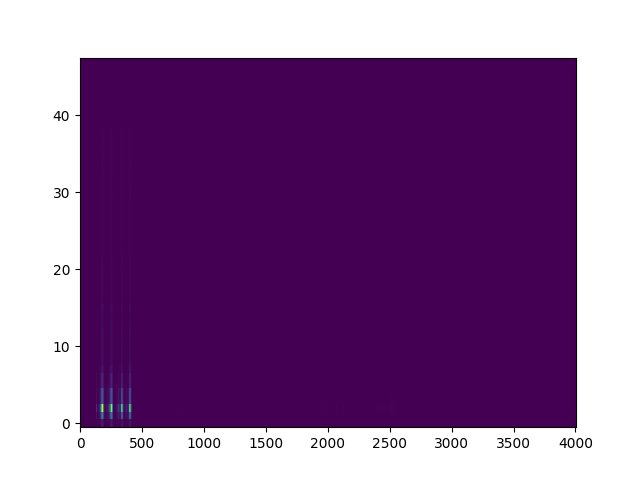

<IPython.core.display.Javascript object>


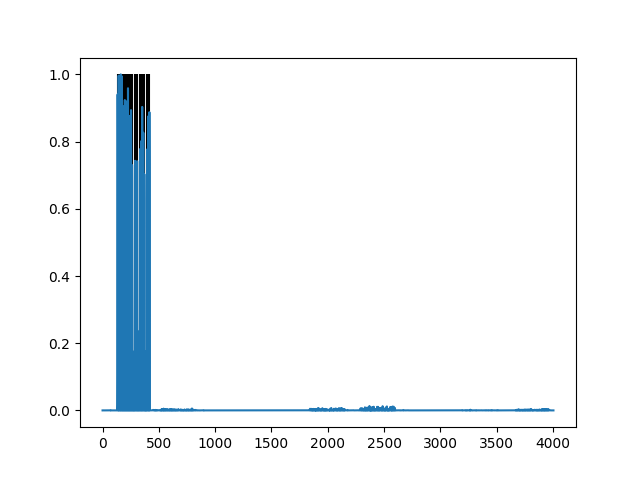

<IPython.core.display.Javascript object>


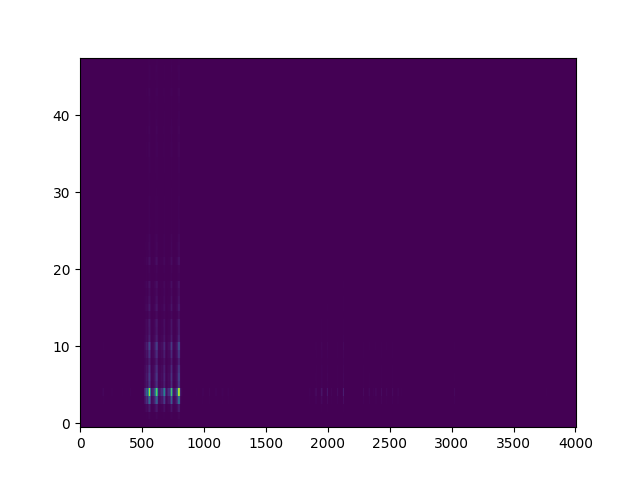

<IPython.core.display.Javascript object>


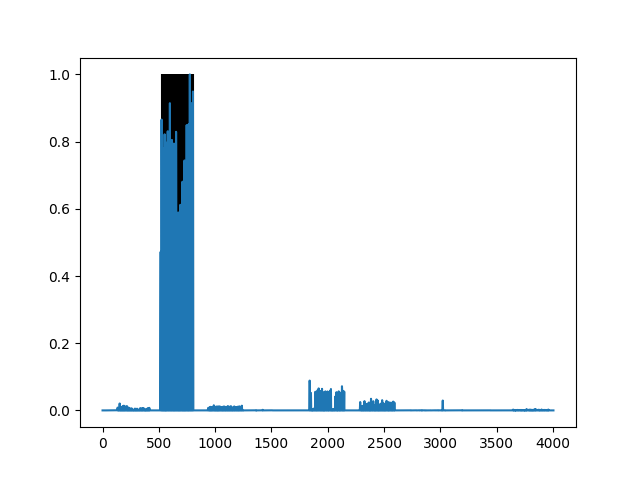

<IPython.core.display.Javascript object>


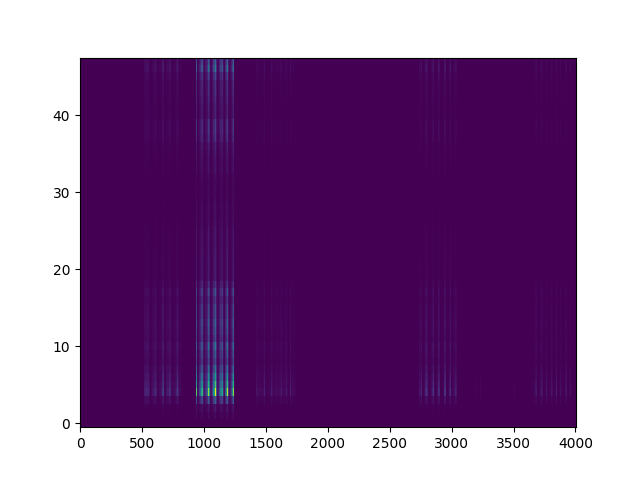

<IPython.core.display.Javascript object>


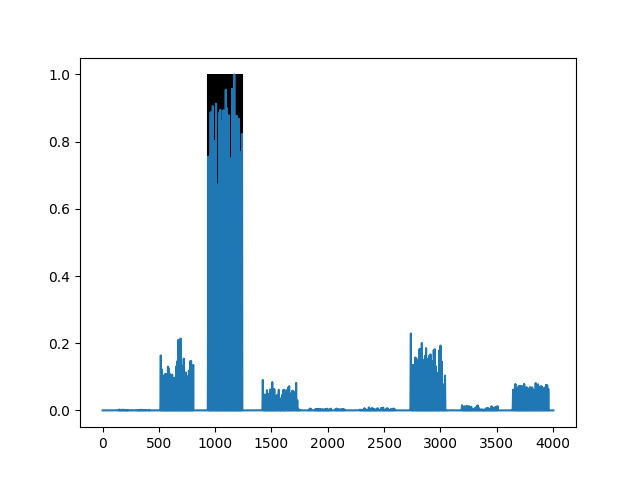

<IPython.core.display.Javascript object>


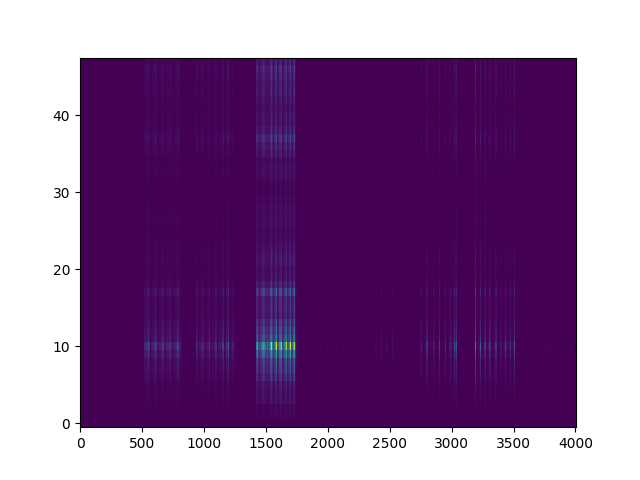

<IPython.core.display.Javascript object>


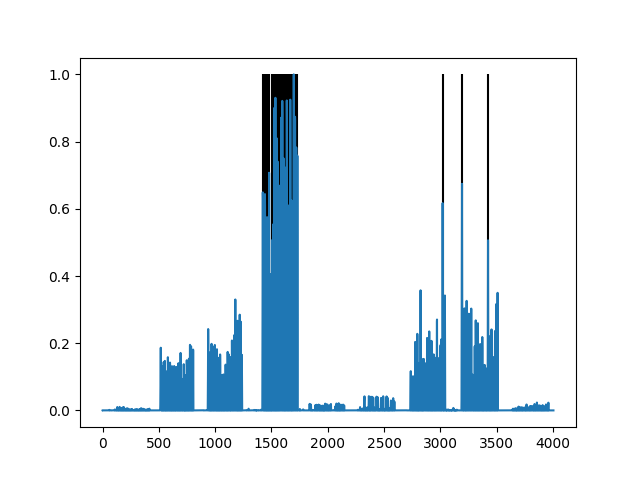

<IPython.core.display.Javascript object>


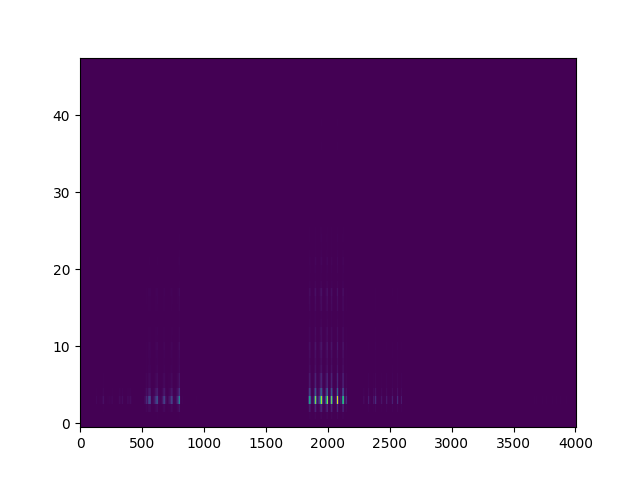

<IPython.core.display.Javascript object>


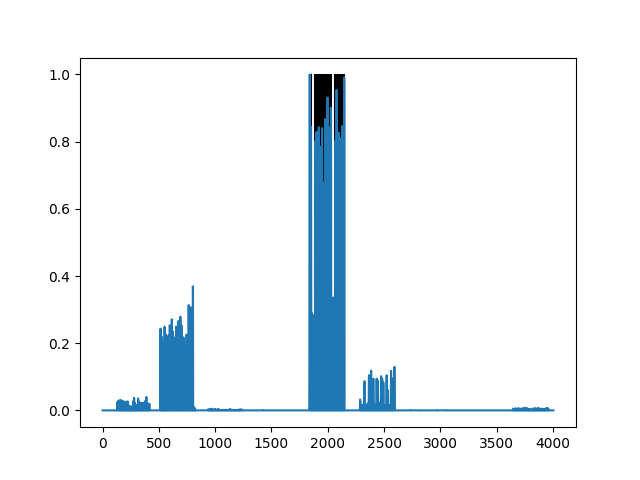

<IPython.core.display.Javascript object>


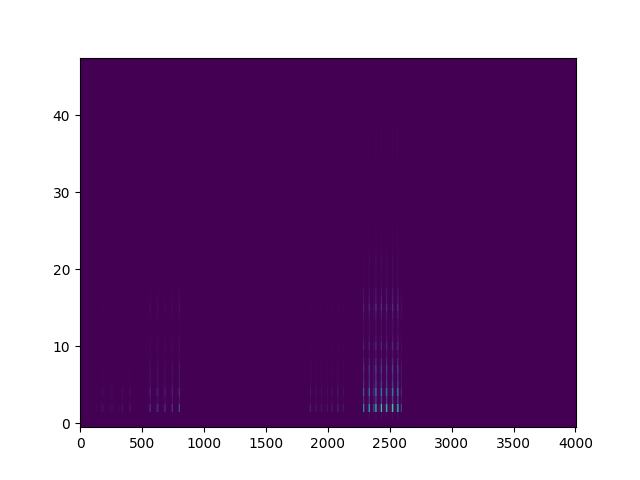

<IPython.core.display.Javascript object>


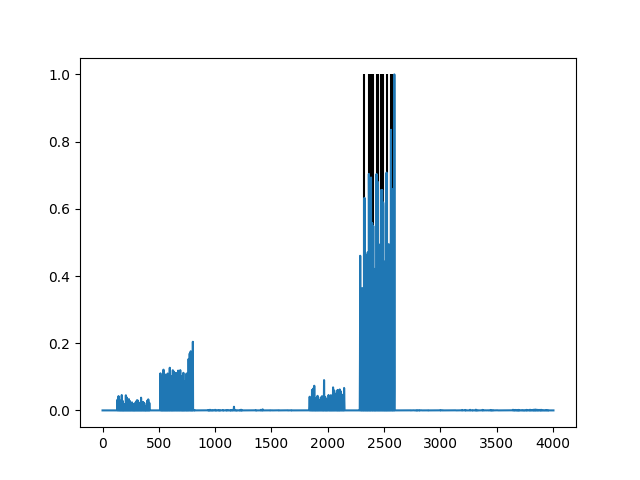

<IPython.core.display.Javascript object>


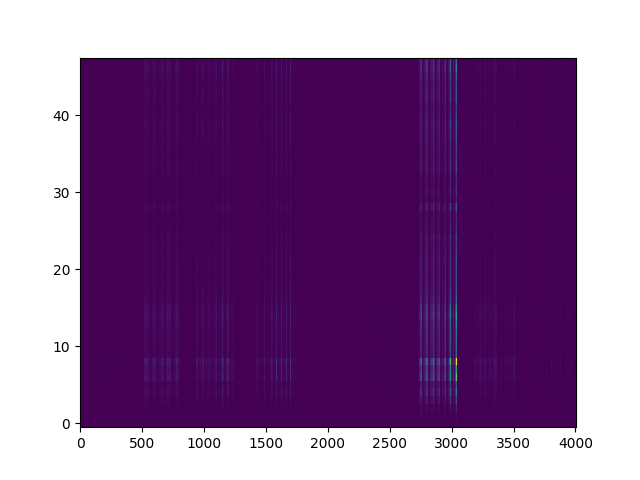

<IPython.core.display.Javascript object>


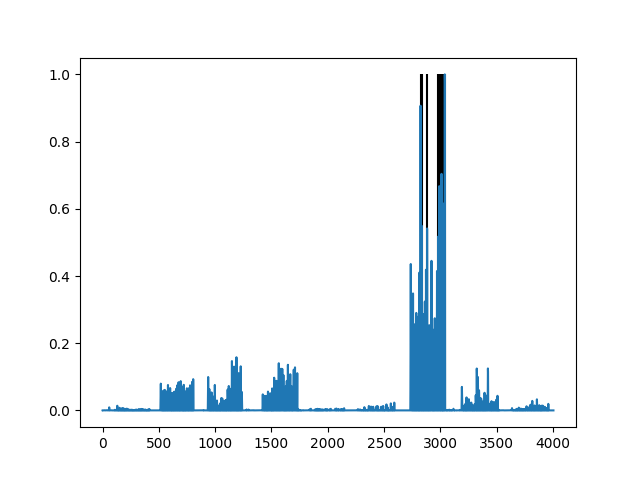

<IPython.core.display.Javascript object>


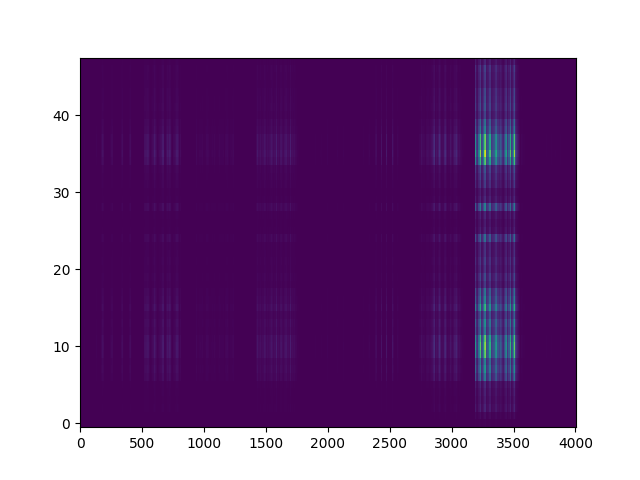

<IPython.core.display.Javascript object>


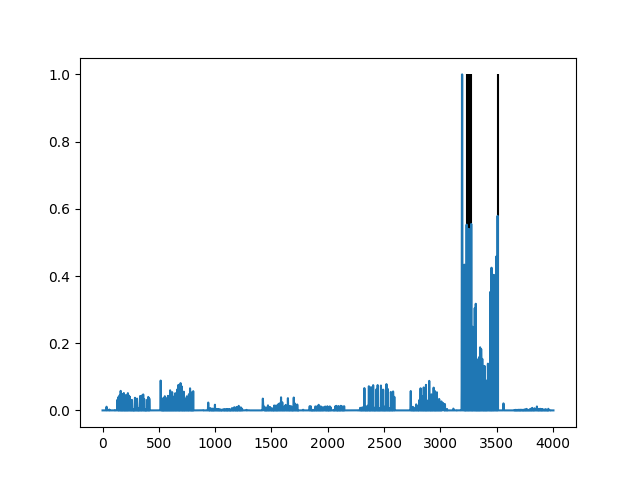

<IPython.core.display.Javascript object>


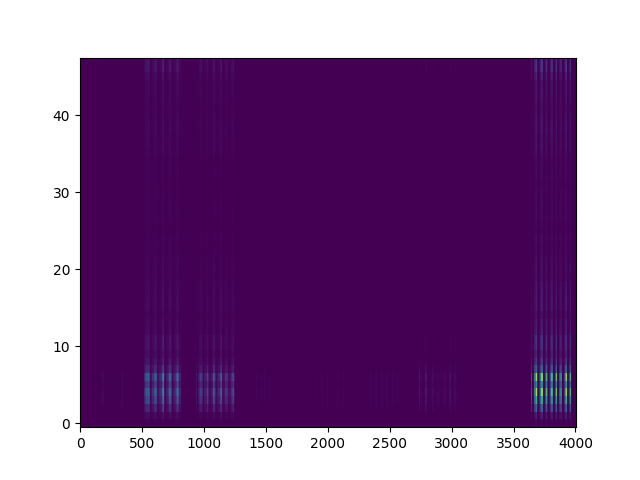

<IPython.core.display.Javascript object>


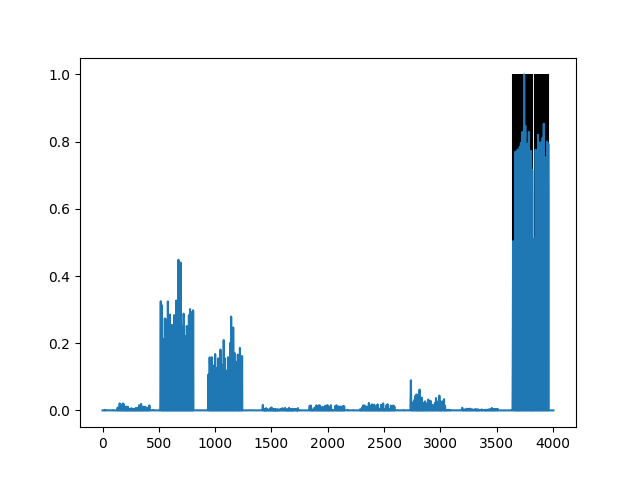

In [14]:

def semi_adaptive_NMF(X,Wpre,n_iterations=100):
    [numRows,numCols] = X.shape
    #No more div by zero
    epsilon=np.nextafter(0,1)
    X = X + epsilon
    W = Wpre
    H = np.ones((nrOfDrums,numCols))
    weight = np.linspace(0,1,n_iterations)
    beta=2
    adaptDegree=1*np.ones((1,nrOfDrums))
    adaptPower=4*np.ones((1,nrOfDrums))
    for i in range(n_iterations):
        WH = epsilon+np.dot(W,H);
        Wt = W.T;
        H = H*(np.dot(Wt,(X*WH**(beta-2))))/( epsilon+np.dot(Wt,(WH**(beta-1))));
        Ht = H.T;
        WH = epsilon+np.dot(W,H)
        W = W*(np.dot((X*WH**(beta-2)),Ht))/(epsilon+(np.dot((WH**(beta-1)),Ht)));  
        blending_parameter = np.matlib.repmat((weight[i]*adaptDegree)**adaptPower,numRows,1)
        blending_parameter[:,adaptDegree[0] > 1.0] = 1
        initWeight = 1-blending_parameter
        W = W*blending_parameter + Wpre*initWeight
        normB = 1/(epsilon+sum(W))
        W = W*normB
    Xpost=np.zeros((nrOfDrums,24, numCols))
    for i in range(nrOfDrums):
        Xpost[i] = np.outer(W[:,i],H[i,:])
    return Xpost, W, H
def semi_adaptive_NMF2(X,Wpre,n_iterations=100, alternate=True):
    if alternate==True:
        n_iterations=n_iterations*2
    [numRows,numCols] = X.shape
    epsilon=0.000000001
    X = X + epsilon
    W = Wpre
    H = np.ones((Wpre.shape[1],numCols))
    weight = np.linspace(0,1,n_iterations)
    beta=4
    adaptDegree=1*np.ones((1,Wpre.shape[1]))
    adaptPower=4*np.ones((1,Wpre.shape[1]))

    for i in range(n_iterations):
        WH = epsilon+np.dot(W,H);
        onemat=np.ones_like(WH)
        Wt = W.T;
        #If alternating, update H every second turn, every second keep constanst.
        if (alternate==True) and (i%2==0):
            H = H*(np.dot(Wt,(WH**float(-2))*X))/( epsilon+np.dot(Wt,(WH)))
        else:
            H = H*(np.dot(Wt,(X/WH)))/( epsilon+np.dot(Wt,onemat))
        Ht = H.T;
        #Update WH if not alternating
        if alternate==False:
            WH = epsilon+np.dot(W,H)
        #If alternating, update W every second turn, every second keep constanst.
        if (alternate==True) and (i%2==1):
            W = W*(np.dot((WH**float(-2))*X,Ht))/(epsilon+(np.dot((WH**float(-1)),Ht)))
        else:
            W = W*(np.dot((X/WH),Ht))/(epsilon+(np.dot(onemat,Ht)))
        alpha=(1-(i/n_iterations))**beta
        W=alpha*Wpre+(1-alpha)*W
        normB = 1/(epsilon+sum(W))
        W = W*normB
        
    Xpost=np.zeros((nrOfDrums,24, numCols))
    for i in range(nrOfDrums):
        Xpost[i] = np.outer(W[:,i],H[i,:])
    return Xpost, W, H


#DRUM TRANSCRIPTION USING PARTIALLY FIXED NON-NEGATIVE MATRIX FACTORIZATION WITH TEMPLATE ADAPTATION
#Chih-Wei Wu, Alexander Lerch
def semi_adaptive_NMF3(X,Wpre,n_iterations=100, alternate=False, adaptive=True, leeseung=False, div=1):
    if alternate==True:
        n_iterations=n_iterations*2
    [numRows,numCols] = X.shape
    epsilon=10**-9
    X = X + epsilon
    Wd = Wpre
    Hd = np.ones((Wd.shape[1],numCols))
    Wh = np.ones_like(Wd)
    Hh = np.ones((Wd.shape[1],numCols))
    weight = np.linspace(0,1,n_iterations)
    beta=4
    onemat=np.ones((numRows,numCols))
    nrOfHarmonics=0
    alpha=(Wd.shape[1]+nrOfHarmonics)/Wd.shape[1]
    div_anneal=div
    err=np.zeros(n_iterations)
    def KLDiv(x,y):
        return sum(sum(x*np.log(x/y)+(y-x)))
    def ISDiv(x,y):
        return sum(sum((x/y)-np.log(x/y)-1))
    for i in range(n_iterations):
        #if i<(n_iterations/2):
        #    div_anneal=2
        #elif i==(n_iterations/2):
        #    div_anneal=1
        #elif i>(n_iterations/2):
        #    div_anneal=0
        #div_anneal-=div/n_iterations
        normB = 1/(epsilon+sum(Wd))
        Wd = Wd*normB
        normB = 1/(epsilon+sum(Wh))
        Wh = Wh*normB
        def updateJ():
            WHd = alpha*(epsilon+np.dot(Wd,Hd));
            WHh = (alpha**(-1))*(epsilon+np.dot(Wh,Hh));
            J=X/(WHd+peta)
            return WHd,WHh,J 
        WHd, WHh, J =updateJ()
        Wdt = Wd.T
        Wht = Wh.T
        #Algorithm according to "Battenberg et al. Live Drum Separation Using Probabilistic Spectral Clustering"
        if leeseung=='bat':
            Hd = Hd*(Wdt@(J*WHd**(div_anneal-2)))/(epsilon+(Wdt@WHd**(div_anneal-1)))
            Hdt = Hd.T
            #Wd = Wd*((WHd**(div_anneal-2)*J)@Hdt)/(epsilon+(WHd**(div_anneal-1)@Hdt))
        if leeseung==False:
            if alternate==False:
                Hd = Hd*(Wdt@(J*WHd**(div-2)))/(epsilon+(Wdt@WHd**(div-1)))
                Hdt = Hd.T
                Hh = Hh*(Wht@(J*WHh**(div-2)))/(epsilon+(Wht@WHh))  
                Hht = Hh.T
                Wh = Wh*((WHh**(div-2)*J)@Hht)/(epsilon+(WHh**(div-1)@Hht))
                Wdh, WHh, J =updateJ()
                if (adaptive==True):
                    Wd = Wd*((WHd**(div-2)*J)@Hdt)/(epsilon+(WHd**(div-1)@Hdt))
            if alternate==True:
                if (i%2==0):
                    Hd = Hd*(Wdt@(J*WHd**(div-2)))/(epsilon+(Wdt@WHd**(div-1)))
                Hdt = Hd.T
                if(i%2==0):       
                    Hh = Hh*(Wht@(J*WHh**(div-2)))/(epsilon+(Wht@WHh))  
                Hht = Hh.T
                if(i%2==0):
                    Wh = Wh*((WHh**(div-2)*J)@Hht)/(epsilon+(WHh**(div-1)@Hht))
                Wdh, WHh, J =updateJ()
                if(i%2==1):
                    if (adaptive==True):
                        Wd = Wd*((WHd**(div-2)*J)@Hdt)/(epsilon+(WHd**(div-1)@Hdt))
                    
        ###Algorithm according to "LEE&SEUNG: Algorithms for non-negative matrix factorization"
        if leeseung==True:
            if (alternate==True) and (i%2==0):
                Hd = Hd*(np.dot(Wdt,J))/(epsilon+np.dot(Wdt,onemat))
            Hdt = Hd.T
            if (alternate==True) and (i%2==0):
                Hh = Hh*(np.dot(Wht,J))/( epsilon+np.dot(Wht,onemat))
            Hht = Hh.T
            if (alternate==True) and (i%2==0):
                Wh = Wh*(np.dot(J,Hht))/(epsilon+(np.dot(onemat,Hht)))
            Wdh, WHh, J =updateJ()
            if (alternate==True) and (i%2==1):
                if adaptive==True:
                    Wd = Wd*(np.dot(J,Hdt))/(epsilon+(np.dot(onemat,Hdt)))

        #Semi adaptive Wd
        if adaptive=='Semi'and (i%2==1):
            gamma=(1-(i/n_iterations))**div_anneal
            Wd=gamma*Wpre[:,Wd.shape[1]]+(1-gamma)*Wd
        if div<=0:
            err[i]=ISDiv(X,Wd@Hd)
        elif div==1:
            err[i]=KLDiv(X,Wd@Hd)
        else :
            err[i]=KLDiv(X,Wd@Hd)
        if (i>=2) :              
            if (abs(err[i] - err[i-1]) / (err[1] - err[i])+epsilon) < 0.0001:
                break
        
    Xpost=np.zeros((Wd.shape[1],numRows, numCols))
    for i in range(int(Wd.shape[1])):
        Xpost[i] = np.outer(Wd[:,i],Hd[i,:])
    return Xpost, Wd, Hd
def semi_adaptive_NMF4(X,Wpre,n_iterations=100, alternate=False, adaptive=True, leeseung=False, div=1.5):
    if alternate==True:
        n_iterations=n_iterations*2
    [numRows,numCols] = X.shape
    epsilon=10**-16
    X = X + epsilon
    W = Wpre
    Wt = W.T
    H = np.ones((W.shape[1],numCols))
    err=np.zeros(n_iterations)
    sparsity=0
    for i in range(W.shape[1]):
        normB = np.linalg.norm(W[:,i], ord=np.inf)
        W[:,i] = W[:,i]/normB
    def KLDiv(x,y):
        return sum(sum(x*np.log(x/y)+(y-x)))
    def ISDiv(x,y):
        return sum(sum((x/y)-np.log(x/y)-1))
    def BRDiv(x,y):
        return sum(sum(((1/(div*(div-1)))*(x**div+(div-1)*y**div-div*x*y**(div-1)))))
    for i in range(n_iterations):
        WH = epsilon+np.dot(W,H)
        #Algorithm according to "Battenberg et al. Live Drum Separation Using Probabilistic Spectral Clustering"
        if leeseung=='bat':
            H = H*(Wt@(X*WH**(div-2)))/(epsilon+(Wt@WH**(div-1))+sparsity)
            Ht = H.T
        
        #Semi adaptive Wd
        if adaptive=='Semi'and (i%2==1):
            gamma=(1-(i/n_iterations))**div
            W=gamma*Wpre[:,W.shape[1]]+(1-gamma)*W
       
    
        normH = np.linalg.norm(H, ord=np.inf)
        #IS-divergence
        if div==0:
            err[i]=ISDiv(X,W@H)+(sparsity*normH)
        #KL-divergence
        elif div==1:
            err[i]=KLDiv(X,W@H)+(sparsity*normH)
        # Bregman-divergence
        else:
            err[i]=BRDiv(X,W@H)+(sparsity*normH)
        if (i>=2) :              
            if (abs(err[i] - err[i-1]) / (err[1] - err[i])+epsilon) < 0.0001:
                break    
    Xpost=np.zeros((W.shape[1],numRows, numCols))
    
    for i in range(int(W.shape[1])):
        Xpost[i] = np.outer(W[:,i],H[i,:])
    return Xpost, W, H
def semi_adaptive_NMFB(X,Wpre,n_iterations=100, alternate=False, adaptive=False, leeseung=False, div=1, sp=0):
    if alternate==True:
        n_iterations=n_iterations*2
    [numRows,numCols] = X.shape
    epsilon=10**-16
    X = X + epsilon
    W = Wpre
    H = np.ones((W.shape[1],numCols))
    err=np.zeros(n_iterations)
    sparsity=sp
    for i in range(W.shape[1]):
        normB = np.linalg.norm(W[:,i], ord=np.inf)
        W[:,i] = W[:,i]/normB
    Wt = W.T
    def KLDiv(x,y):
        return sum(sum(x*np.log(x/y)+(y-x)))
    def ISDiv(x,y):
        return sum(sum((x/y)-np.log(x/y)-1))
    def BRDiv(x,y):
        return sum(sum((( 1 / (div * (div-1) )) * ( x**div + (div-1) * y**div -div * x * y**(div-1) ))))
    def LS(x,y):
        return sum(sum((x-y)**2))
    WH = epsilon+np.dot(W,H)
    for i in range(n_iterations):
        
        #Algorithm according to "Battenberg et al. Live Drum Separation Using Probabilistic Spectral Clustering"
        if leeseung=='bat':
            Himin=H
            H = H*(Wt@(X*WH**(div-2)))/(epsilon+(Wt@WH**(div-1))+sparsity)
            Ht = H.T
        WH = epsilon+np.dot(W,H)    
        normH = np.linalg.norm(H, ord=np.inf)

        if div==0:
            err[i]=ISDiv(X,WH)+(sparsity*normH)
            #print('Error: {}'.format(err[i]))
        #KL-divergence
        elif div==1:
            err[i]=KLDiv(X,WH)+(sparsity*normH)
            #print('Error: {}'.format(err[i]))
        elif div == 2:
            err[i]=LS(X,WH)+(sparsity*normH)
            #print('Error: {}'.format(err[i]))
        # Bregman-divergence
        else:
            err[i]=BRDiv(X,WH)+(sparsity*normH)
            #print('Error: {}'.format(err[i]))
        sparsity=1/err[i]
        if (i>=2) :              
            if (abs(err[i] - err[i-1]) / (err[1] - err[i])+epsilon) < 0.005:
                #print('Iterations: {}'.format(i))
                #print('Error: {}'.format(err[i]))
                break    
    Xpost=np.zeros((W.shape[1],numRows, numCols))
    for i in range(int(W.shape[1])):
        Xpost[i] = np.outer(W[:,i],H[i,:])
    return Xpost, W, H
#try:
#
#    buffer=madmom.audio.Signal("./oikeetsamplet/drumBeat.wav",frame_size=2048, hop_size=HOP_SIZE)
#    
#except Exception as e:
#    print (e)
#    print('jotain meni vikaan!')
##proc=madmom.audio.filters.BarkFilterbank(np.array(range(0,16384, 16)))
##filt_spec = madmom.audio.spectrogram.FilteredSpectrogram(buffer, filterbank=proc, sample_rate=44100, fmin=20)
filt_spec=get_preprocessed_spectrogram(comp_buffer)
#filt_spec=muLaw(filt_spec, mu=10**8)
#filt_spec=(filt_spec+50)
#filt_spec=np.sqrt(filt_spec)
#filt_spec=madmom.audio.Spectrogram(buffer)
#filt_spec=muLaw(filt_spec, mu=0.0001)
#for i in range (nrOfDrums):
#
#    plt.figure()
#    plt.plot(fpr.T[i])
#    plt.ylim(0,24)
#    plt.figure()
#    plt.plot(fpr.T[i+nrOfDrums])
#    plt.ylim(0,24)

Xpost, W, H = semi_adaptive_NMFB(filt_spec.T,fpr,
                                 n_iterations=20000, alternate=False,
                                 adaptive=False, leeseung='bat', div=0)

Hmu=np.zeros_like(H)
Wp=np.linalg.pinv(W)
#for i in range (nrOfDrums):
    #Xpost[i]=muLaw(Xpost[i].T, mu=0.5).T
    #Hmu[i]=(Wp[i]@Xpost[i])
#from librosa.core import istft
def smoothed_subband_mean(Y):
    kernel = np.hanning(10)
    from scipy.signal import convolve2d
    smoothY=convolve2d(Y, kernel[:, np.newaxis], 'same')
    abs_smoothY=abs(smoothY)
    z=np.zeros(Y.shape[0])
    for n in range(Y.shape[0]):
        z[n]=np.mean(abs_smoothY[n])
    ground=np.percentile(z, 1)
    print(ground)
    z=z-ground
    return z/max(z)
for i in range (nrOfDrums):
    #print(framed.shape)
    #Xpost[i].__class__ = madmom.audio.spectrogram.FilteredSpectrogram
    #print(Xpost[i].ndim)
    #diff=madmom.audio.spectrogram.SpectrogramDifference()
    #superflux_3 = madmom.features.onsets.superflux(Xpost[i].T)
    #superflux_3=superflux_3/(superflux_3.max(axis=0) )
    plt.figure()
    
    plt.imshow(Xpost[i], aspect='auto', origin='lower')
    H[i]=superflux(W[i],H[i])
    peaks=madmom.features.onsets.peak_picking(H[i],0.5)
    
    #kernel = np.hanning(29)
    #kernel =np.kaiser(10,5)
    #from scipy.signal import convolve
    #H[i]=convolve(H[i], kernel, 'same')
    plt.figure()
    plt.plot((H[i]))
    plt.vlines(peaks,0,max(H[i]))
    #drums[i].set_frequency_pre(W.T[i])
    
   #z=smoothed_subband_mean((Xpost[i].T))
   #peaks=madmom.features.onsets.peak_picking(z,0.5, pre_max=10)
   #plt.figure()
   #plt.plot(z)
   #plt.vlines(peaks,0,max(z))


<IPython.core.display.Javascript object>


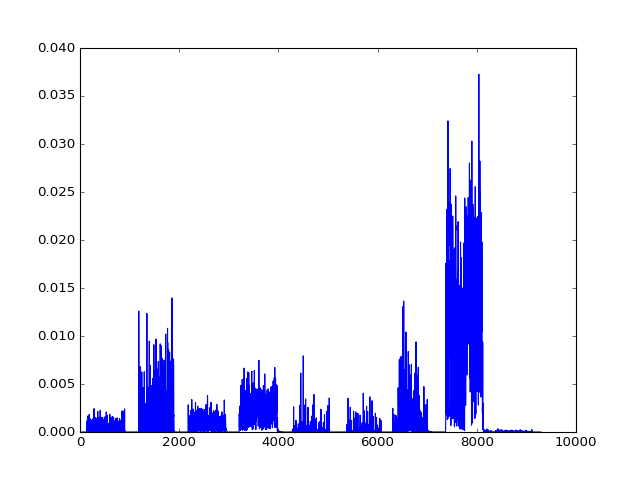

<IPython.core.display.Javascript object>


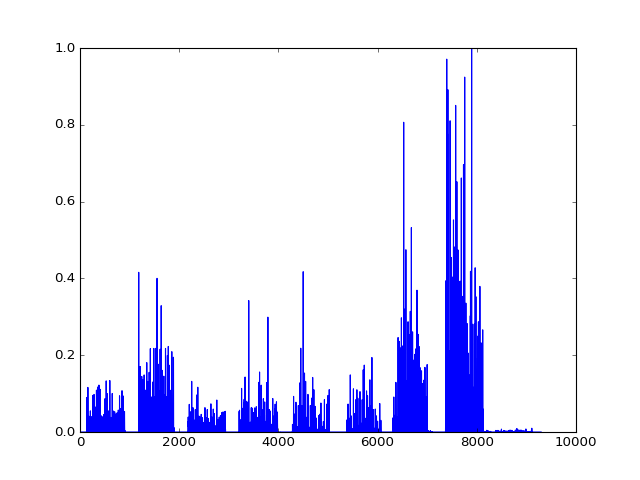

In [697]:
def superflux(A,B):
    spec_x=np.outer(A,B)
    diff = np.zeros_like(spec_x.T)
    size = (2,16)
    max_spec = maximum_filter(spec_x.T, size=size)
    diff[1:] = (spec_x.T[1:] - max_spec[: -1])
    pos_diff = np.maximum(0, diff)
    sf = np.sum(pos_diff, axis=1)
    sf=sf/max(sf)
    return sf

from scipy.ndimage.filters import maximum_filter
# widen the spectrogram in frequency dimension

plt.figure()  
plt.plot(H[7].T)
sf=superflux(W[7],H[7])

plt.figure()
plt.plot(sf)

##log_filt_spec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(spec_x.T, num_bands=24)
##kernel = np.hanning(1)
##from scipy.signal import convolve2d
##smoothY=convolve2d(kick.T, kernel[:, np.newaxis], 'same')
##kick=abs(smoothY.T)
#
#diff = np.zeros_like(spec_x.T)
#size = (1,3)
#max_spec = maximum_filter(spec_x.T, size=size)
#diff[1:] = (spec_x.T[1:] - max_spec[: -1])
#pos_diff = np.maximum(0, diff)
#plt.figure()
#plt.imshow(pos_diff.T, aspect='auto', origin='lower')
#
## keep only the positive differences
#
## sum everything to get the spectral flux
#sf = np.sum(pos_diff, axis=1)
#sf=sf/max(sf)
##sf=sf/max(sf)
##diff[Xpost[0].shape[1]:] = (Xpost[0][Xpost[0].shape[1]:]-diff_spec[:-Xpost[0].shape[1]])
#plt.figure()  
#plt.plot(sf)


<IPython.core.display.Javascript object>


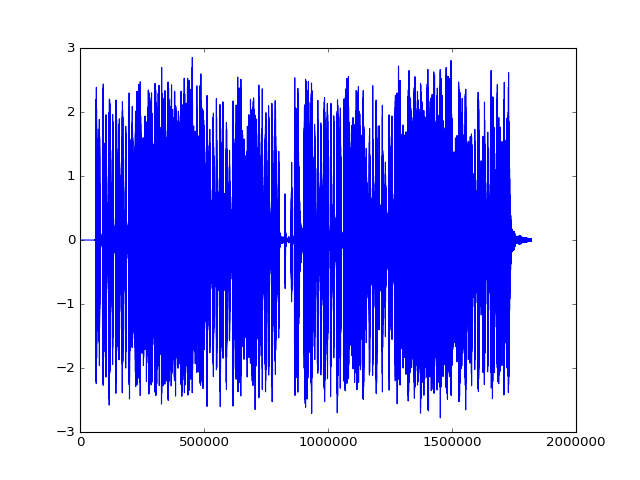

<IPython.core.display.Javascript object>


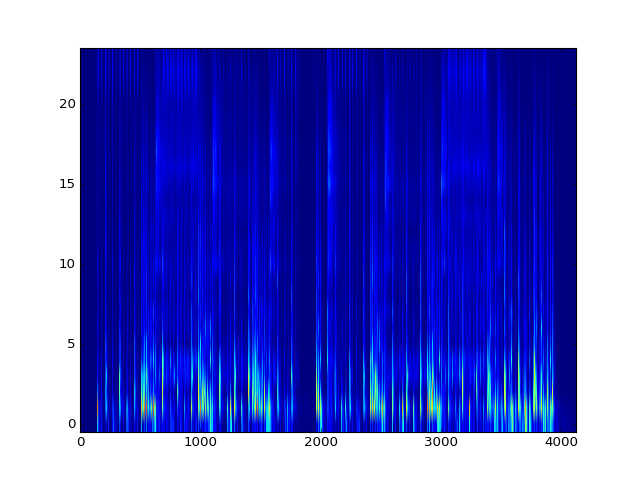

<IPython.core.display.Javascript object>


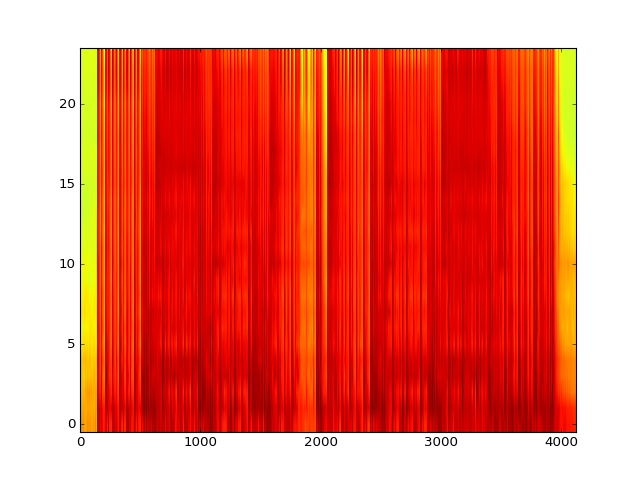

2047


In [119]:
buffer=madmom.audio.Signal("./oikeetsamplet/drumBeat.wav",frame_size=2048, hop_size=HOP_SIZE)
filt_spec=get_preprocessed_spectrogram(buffer)
clipped_frames=np.zeros_like(buffer)
plt.figure()
plt.plot(buffer)
plt.figure()

plt.imshow(filt_spec.T, aspect='auto', origin='lower')

plt.figure()
b=muLaw(filt_spec,mu=10**8).T
plt.imshow(np.sqrt(b), aspect='auto', origin='lower')

for i in range(len(buffer)): 
    
    if buffer[i]==buffer[i-1]:
        clipped_frames[i-1]=1
print(len(clipped_frames[clipped_frames==1]))
               

In [ ]:
try:

    buffer=madmom.audio.Signal("./oikeetsamplet/drumBeat.wav",frame_size=2084, hop_size=HOP_SIZE)
    
except Exception as e:
    print (e)
    print('jotain meni vikaan!')
proc=madmom.audio.filters.BarkFilterbank(np.array(range(0,16384, 16)))
filt_spec = madmom.audio.spectrogram.FilteredSpectrogram(buffer, filterbank=proc, sample_rate=44100, fmin=20)
plt.figure()
plt.imshow(1000000*filt_spec.T, aspect='auto', origin='lower')
def muLaw(Y, frame_length=2048, hop_size=441, mu=10**8):
    #n=frames, i=sub-bands
    for n in range(Y.shape[0]):
        for i in range(Y.shape[1]):
            x_i_n=Y[n,i].flatten()@Y[n,i].flatten()
            Y[n,i]= (np.log10(1+mu*x_i_n))/(np.log10(1+mu))
    return Y
filt_spec=filt_spec**2
filt_spec=muLaw(filt_spec, mu=10**8)

#filt_spec=muLaw(filt_spec, mu=10**8)
#filt_spec=filt_spec**.5
plt.figure()
plt.imshow(filt_spec.T, aspect='auto', origin='lower')

z=smoothed_subband_mean(filt_spec)**2
peaks=madmom.features.onsets.peak_picking(z,0.5, pre_max=1)
plt.figure()
plt.plot(z)
plt.vlines(peaks,0,max(z))
#
#nrOfDrums=9
#HOP_SIZE=441
#"""Jotain tähän tyyliin sitten sämplejä talteen"""
#nrOfDrums=9
#nrOfPeaks=32
#nrOfDrumClasses=3
#fpr=np.zeros((24, nrOfDrums))
#frames=np.zeros((8192,nrOfDrums*nrOfPeaks))
#drums=[]
#list_X=[]
#list_y=[]
#def getPeaksFromBuffer(buffer, resolution, numHits, highEmph=0):
#    proc=madmom.audio.filters.BarkFilterbank(np.array(range(0,16384, 16)))
#    filt_spec = madmom.audio.spectrogram.FilteredSpectrogram(buffer, filterbank=proc, sample_rate=44100, fmin=10)
#    def findDefBins(frames, filteredSpec):
#        mod=PCA()
#        mod2=FastICA(n_components=1)
#        intermediateResult=[]
#        topThree=np.array(mod.fit_transform(filteredSpec.T))
#        icas=np.array(mod2.fit_transform(topThree[:,:3]))
#        for j in range(icas.shape[1]):
#            intermediateResult.append(icas[:,j])
#           
#        from sklearn.cluster import KMeans
#        eigenDrum=[]
#
#        kmeans = KMeans(n_clusters=1, random_state=0).fit(intermediateResult)
#        eigenDrum=kmeans.cluster_centers_
#        return(eigenDrum)
#
#    log_filt_spec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(buffer,num_bands=24,sample_rate=44100, fmin=10)
#    superflux_3 = madmom.features.onsets.superflux(filt_spec)
#    superflux_3=superflux_3/(superflux_3.max(axis=0) )
#    threshold=1
#    searchSpeed=0.2
#    peaks=cleanDoubleStrokes(madmom.features.onsets.peak_picking(superflux_3,threshold),resolution)
#    while(peaks.shape!=(numHits,)):
#        #Make sure we don't go over numHits
#        #There is a chance of an infinite loop here!!! Make sure that don't happen
#        if(peaks.shape[0]>numHits):
#            threshold+=searchSpeed
#            searchSpeed=searchSpeed/2
#        threshold-=searchSpeed
#        peaks=cleanDoubleStrokes(madmom.features.onsets.peak_picking(superflux_3,threshold),resolution)
#    buff=madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(buffer, sample_rate=44100, fmin=5 ,num_bands=24)
#    buffdiff = madmom.audio.spectrogram.SpectrogramDifference(filt_spec, positive_diffs=True, diff_max_bins=3)
#    definingBins=findDefBins(peaks,buffdiff)
#    return peaks, definingBins, threshold
#            
#                
#          
####Tässä pitää napata talteen framet/sample
#for i in range(nrOfDrums):
#    try:
#        
#        soundcheck=False
#        print("./drum{}.wav".format(i))
#        buffer=madmom.audio.Signal("./oikeetsamplet/drum{}.wav".format(i),frame_size=2048, hop_size=HOP_SIZE)
#        CC1, fpr[:,i], threshold=getPeaksFromBuffer(buffer,1,nrOfPeaks,-1)
#        plt.figure()
#        plt.plot(fpr[:,i])
#        fpr[:,i]=fpr[:,i]/fpr[:,i].max()
#    except Exception as e: 
#        print(e)
#        print('samples not found, please soundcheck!')
#        print("Play drum nr. {}".format(i+1))
#        CC1, fpr[:,i], threshold, buffer= getStompTemplate(nrOfPeaks,recordingLength=2,highEmph=-1) 
#        outBuffer=unFrameSignal(buffer)
#        madmom.io.audio.write_wave_file(buffer, './drum{}.wav'.format(i),sample_rate=44100)
#    if(True):
#        templates=[]
#        samples=[]
#        midinotes=[36,38,42,46,50,45,51,49,40]
#        def ZCR(signal):
#            ZC=0
#            for i in range(1,signal.shape[0]):
#                if np.sign(signal[i-1])!=np.sign(signal[i]):
#                    ZC+=1
#            return ZC
#        
#        for j in range(len(CC1)):
#            #print(CC1[j])
#            time=CC1[j]
#            tinyBuff=madmom.audio.signal.signal_frame(buffer,time, frame_size=4*HOP_SIZE, hop_size=HOP_SIZE, origin=0)
#            fiba=madmom.audio.spectrogram.FilteredSpectrogram(tinyBuff,filterbank=MelFilterbank,sample_rate=44100)
#            mfcc2=madmom.audio.cepstrogram.MFCC(fiba, num_bands=32, mul=5, add=2)
#            mfcc_delta = librosa.feature.delta(mfcc2)
#            feats=np.append(mfcc2[0],[mfcc2[1],mfcc2[2],mfcc2[3], mfcc_delta[0], mfcc_delta[1]])
#            templates.append(np.append(feats,[np.append([ZCR(tinyBuff)], 
#                                                        [np.append([scipy.stats.kurtosis(tinyBuff)]
#                                                                   ,[np.append([scipy.stats.skew(tinyBuff)],[spectral_centroid(tinyBuff)])])])]))
#            samples.append(tinyBuff) #8192 for 4 frames
#           
#        drums.append(Drum(name=[i],templates=templates, samples=samples, threshold=threshold, midinote=midinotes[i]))
#try:
#
#    buffer=madmom.audio.Signal("./oikeetsamplet/drumBeat.wav",frame_size=2048, hop_size=HOP_SIZE)
#    
#except Exception as e:
#    print (e)
#    print('jotain meni vikaan!')
#proc=madmom.audio.filters.BarkFilterbank(np.array(range(0,16384, 16)))
#filt_spec = madmom.audio.spectrogram.FilteredSpectrogram(buffer, filterbank=proc, sample_rate=44100)
#Y = madmom.audio.spectrogram.SpectrogramDifference(filt_spec, positive_diffs=True, diff_max_bins=3)
#Y=abs(Y)
#plt.figure()
#plt.imshow(Y.T, aspect='auto', origin='lower')
#fpp=np.linalg.pinv(fpr)
#for i in range (nrOfDrums):
#    plt.figure()
#    plt.plot(fpr[i])
###Multiplying the overall spectrogram by the pseudo-inverse of the prior frequency subspaces yield estimates of the amplitude basis functions, tˆ :
###The pseudo inverse is wrong??? Better or equal results with just a transpose??
#tHat=np.dot(fpp,Y.T).T
##print(tHat.min())
#for i in range (nrOfDrums):
#    plt.figure()
#    plt.plot(tHat[:,i])
#    
#ica = FastICA(n_components=nrOfDrums)
#t = (ica.fit_transform(tHat))
##t2=t
#print(t.shape)
#for i in range (nrOfDrums):
#    plt.figure()
#    plt.plot((t[:,i]))
#plt.figure()
#plt.plot(t)

In [184]:
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.utils import resample

n_samples=2**17
#n_samples=len(list_y)
#bootsrap extra samples by resampling with replacement
random_state=0
X,y=resample(np.array(list_X),np.array(list_y), n_samples=n_samples)
#X_train,y_train=resample(np.array(X[:int(n_samples*0.9)]),np.array(y[:int(n_samples*0.9)]),n_samples=n_samples*10)
scaler=preprocessing.MinMaxScaler()
X=scaler.fit_transform(X)
#print(X_train.shape)
X_train, y_train = X[:n_samples*0.8], y[:n_samples*0.8]
X_train_valid, y_train_valid = X[:n_samples*0.9], y[:n_samples*0.9]
X_valid, y_valid = X[n_samples*0.8:n_samples*0.9], y[n_samples*0.8:n_samples*0.9]
X_test, y_test = X[n_samples*0.9:], y[n_samples*0.9:]
#X_test, y_test = resample(np.array(X[int(n_samples*0.9):]),np.array(y[int(n_samples*0.9):]),n_samples=n_samples)
#X_test=scaler.fit_transform(X_test)
#train_X, train_y=[np.array(list_X),np.array(list_y)]
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_test, y_test)
print(np.unique(y_train).shape)
num_labels = np.unique(y_train).shape[0]
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_leaves': 9,
    'learning_rate': 0.5,
    'max_depth':1,
    'max_bin': 516, 
    'subsample_for_bin': 100,
    'subsample': 1, 
    'subsample_freq': 100, 
    'colsample_bytree': 0.9, 
    'reg_alpha': 0.01, 
    'reg_lambda': 0.01,
    'min_split_gain': 0.5, 
    'min_child_weight': 5, 
    'min_child_samples': 5, 
    'scale_pos_weight':100,
    #'feature_fraction': 0.5,
    #'bagging_fraction': 0.5,
    #'bagging_freq': 2,
    'verbose': 1,
    'device':'cpu',
    'num_threads':8,
    #'min_data':1,
    #'min_data_in_bin':1,
    'num_class':num_labels
}
print('Start training...')

gbm = lgb.train(params,
        lgb_train,
        num_boost_round=300,
        valid_sets=[lgb_valid],
        early_stopping_rounds=100, verbose_eval=10)


/Users/mikkelbom/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/mikkelbom/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/mikkelbom/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/mikkelbom/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(9,)
Start training...
Training until validation scores don't improve for 100 rounds.
[10]	valid_0's multi_logloss: 1.20703
[20]	valid_0's multi_logloss: 1.03474
[30]	valid_0's multi_logloss: 0.954247
[40]	valid_0's multi_logloss: 0.903465
[50]	valid_0's multi_logloss: 0.867653
[60]	valid_0's multi_logloss: 0.840424
[70]	valid_0's multi_logloss: 0.820223
[80]	valid_0's multi_logloss: 0.802666
[90]	valid_0's multi_logloss: 0.787343
[100]	valid_0's multi_logloss: 0.775538


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.mixture import GaussianMixture
n_samples=2**14
#n_samples=len(list_y)
#bootsrap extra samples by resampling with replacement
X,y=resample(np.array(list_X),np.array(list_y),n_samples=n_samples, random_state=0)
scaler=preprocessing.MinMaxScaler()
X=scaler.fit_transform(X)
X_train, y_train = X[:n_samples*0.8], y[:n_samples*0.8]
X_train_valid, y_train_valid = X[:n_samples*0.9], y[:n_samples*0.9]
X_valid, y_valid = X[n_samples*0.8:n_samples*0.9], y[n_samples*0.8:n_samples*0.9]
X_test, y_test = X[n_samples*0.9:], y[n_samples*0.9:]
#X,y=resample(np.array(list_X),np.array(list_y), replace=False)
#X_train,y_train=resample(np.array(X[:int(n_samples*0.9)]),np.array(y[:int(n_samples*0.9)]),n_samples=n_samples*10)
#scaler=preprocessing.MinMaxScaler()
#X_train=scaler.fit_transform(X_train)
#X_test, y_test = resample(np.array(X[int(n_samples*0.9):]),np.array(y[int(n_samples*0.9):]),n_samples=n_samples)
#X_test=scaler.fit_transform(X_test)
n_classes = np.unique(y_train).shape[0]
from time import time
t0=time()
#n_estimators = 20
#svc = BaggingClassifier(KNeighborsClassifier(n_neighbors=nrOfDrums,n_jobs=-1, leaf_size=5), max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1)
#svc.fit(X_train, y_train)
#preds_SVC=svc.predict_proba(X_test)
#score = log_loss(y_test, preds_SVC)
#print('SVM ',score)
#print ('SVM time:%0.2f' %(time()-t0))
#X,y=resample(np.array(list_X),np.array(list_y),n_samples=n_samples)
#scaler=preprocessing.MinMaxScaler()
#X=scaler.fit_transform(X)
#X_train, y_train = X[:n_samples*0.8], y[:n_samples*0.8]
#X_train_valid, y_train_valid = X[:n_samples*0.9], y[:n_samples*0.9]
#X_valid, y_valid = X[n_samples*0.8:n_samples*0.9], y[n_samples*0.8:n_samples*0.9]
#X_test, y_test = X[n_samples*0.9:], y[n_samples*0.9:]
#t0=time()           
##
proc=madmom.audio.filters.BarkFilterbank(np.array(range(0,16384, 16)))
#clf = RandomForestClassifier(n_estimators=1234,n_jobs=-1, verbose=0, criterion='entropy')
clf = KNeighborsClassifier(n_neighbors=nrOfDrums,n_jobs=-1, leaf_size=5)
##
clf.fit(X_train, y_train)
print ('CLF time:%0.2f' %(time()-t0))
t0=time()
preds_CLF=clf.predict_proba(X_test)

#for i in range(preds_CLF.shape[0]):
#    preds_CLF[i]=preds_CLF[i]/max(preds_CLF[i])
score = log_loss(y_test, preds_CLF)
print('CLF ',score)

t0=time() 
GMM = GaussianMixture(n_components=nrOfDrums)
GMM.fit(X_train, y_train)
print ('GMM time:%0.2f' %(time()-t0))
t0=time()
preds_GMM=GMM.predict_proba(X_test)

#for i in range(preds_CLF.shape[0]):
#    preds_CLF[i]=preds_CLF[i]/max(preds_CLF[i])
score = log_loss(y_test, preds_GMM)
print('GMM ',score)
preds_CNN=cnn.predict(X_test)
#for i in range(preds_CNN.shape[0]):
#     preds_CNN[i]=preds_CNN[i]/max(preds_CNN[i])
#print (preds_CNN)
score = log_loss(y_test, preds_CNN)
print('CNN ',score)

#preds_LGB=gbm.predict(X_test)
#for i in range(preds_LGB.shape[0]):
#    preds_LGB[i]=preds_LGB[i]/max(preds_LGB[i])
#score = log_loss(y_test, preds_LGB)
#print('LGB ',score)



#preds_SVC=svc.predict_proba(X_test)
#score = log_loss(y_test, preds_SVC)
#print('SVM ',score)
#
preds_CNN=(preds_CNN+preds_CLF)
#print (clf_probs.shape)
score = log_loss(y_test, preds_CNN)
print(score)
print ('preds time:%0.2f' %(time()-t0))
t0=time()


In [31]:
import numpy as np
import madmom
HOP_SIZE=441
print('KOMPPIA! (lopeta ctrl+C)')
buffer=np.zeros(HOP_SIZE)
try:
    strm=madmom.audio.signal.Stream(sample_rate=44100, num_channels=1,frame_size=2048, hop_size=HOP_SIZE)
    for i in strm:
            buffer=np.append(buffer,[i[:HOP_SIZE]])
            #print(buffer.shape)
except:
    print(buffer.shape)
    madmom.io.audio.write_wave_file(buffer, './drumBeat.wav',sample_rate=44100)
    print('vittu')
print("morjens")

KOMPPIA! (lopeta ctrl+C)
(1819125,)
vittu
morjens


In [ ]:
proc=madmom.audio.filters.BarkFilterbank(np.array(range(0,16384, 16)))
filt_spec = madmom.audio.spectrogram.FilteredSpectrogram(buffer, filterbank=proc, sample_rate=44100)
Y = madmom.audio.spectrogram.SpectrogramDifference(filt_spec, positive_diffs=True, diff_max_bins=3)

Yl=Y
Y=abs(Y)
Pe=np.ones(Y.shape[1])
for i in range(Y.shape[1]-1):
    Yl[:,i+1]=20*np.log10(Y[:,i]/Y[:,i+1])
    Pe[i]=sum(Yl[:,i+1]>0.5)
plt.figure()
plt.imshow(abs(Yl.T), aspect='auto', origin='lower')
plt.figure()
plt.plot(Pe)
Y = madmom.audio.spectrogram.SpectrogramDifference(filt_spec, positive_diffs=True, diff_max_bins=3)
plt.figure()
plt.imshow(Y.T, aspect='auto', origin='lower')
print(Yl[774, :])

In [ ]:
#print('KOMPPIA!')
#CC4, f4, treshold, buff4=getStompTemplate(32, recordingLength=2)
import madmom
import numpy as np
import madmom.audio.cepstrogram
from madmom.audio.filters import MelFilterbank
from madmom.audio.filters import RectangularFilterbank
from sklearn.decomposition import FastICA, NMF
import matplotlib.pyplot as plt
import librosa
import pyaudio
import time
import scipy
nrOfDrums=9
HOP_SIZE=441
try:

    buffer=madmom.audio.Signal("./oikeetsamplet/drumTest.wav",frame_size=2048, hop_size=HOP_SIZE)
    
except Exception as e:
    print (e)
    print('jotain meni vikaan!')
proc=madmom.audio.filters.BarkFilterbank(np.array(range(0,16384, 16)))
filt_spec = madmom.audio.spectrogram.FilteredSpectrogram(buffer, filterbank=proc, sample_rate=44100)
Y = madmom.audio.spectrogram.SpectrogramDifference(filt_spec, positive_diffs=True, diff_max_bins=3)
Y=abs(Y)
#Y = np.log(1+np.dot(2,Y))
#sf = madmom.features.onsets.superflux(Yl)
#sf=sf/(sf.max(axis=0))
#plt.figure()
#plt.plot(sf)
#Yl = np.log(1+np.dot(250,Y))
#sf = madmom.features.onsets.superflux(Yl)
#sf=sf/(sf.max(axis=0))
#plt.figure()
#plt.plot(sf)
#Yl = np.log(1+np.dot(500,Y))
#print (Yl.shape)
#sf = madmom.features.onsets.superflux(Yl)
#sf=sf/(sf.max(axis=0))
#plt.figure()
#plt.plot(sf)
#Y = madmom.audio.spectrogram.SpectrogramDifference(madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(buffer, sample_rate=44100, fmin=5 ,num_bands=24), positive_diffs=True, diff_max_bins=3)
#Yl = np.log(1+np.dot(500,Y))
#Yl=Y
#log_filt_spec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(buff4,num_bands=24,sample_rate=44100, fmin=1, fmax=22050)
#superflux_3 = madmom.features.onsets.superflux(filt_spec)
#superflux_3=superflux_3/(superflux_3.max(axis=0) )
#Y = buff4
#fpp=np.linalg.pinv(fpr)
#plt.figure()
#plt.imshow(Y.T, aspect='auto', origin='lower')
#
#print(Y.min())
#print(fpp.max())
#print(fpp.min())
#Multiplying the overall spectrogram by the pseudo-inverse of the prior frequency subspaces yield estimates of the amplitude basis functions, tˆ :
#The pseudo inverse is wrong??? Better or equal results with just a transpose??
#tHat=np.dot(fpp,Y.T).T
#print(tHat.min())
#for i in range (nrOfDrums):
#    plt.figure()
#    plt.plot(tHat[:,i]/max(tHat[:,i]))
###However the estimated amplitude basis functions returned are not independent and so ICA is carried out on tˆ to give:
#ica = FastICA(n_components=nrOfDrums)
#t = (ica.fit_transform(tHat))
#t2=t
#print(t.shape)
#plt.figure()
#plt.plot(t)
#for i in range (nrOfDrums):
#    ##Change to positive and move base to 0
#    #if abs(t[:,i].min())>t[:,i].max():
#    #    t[:,i]=-1*t[:,i]
#    ##t[:,i][t[:,i]<0]=0
#    #t[:,i]=t[:,i]+(abs(t[:,i].min(axis=0)))
#    ##Normalize
#    ##mean(a(i:i+n-1)),1:n:length(a)-n+1)'; % the averaged vector
#    #
#    ##t=abs(t)
#    #t[:,i]=(t[:,i]/(t[:,i].max(axis=0)))
#    #Plot for sanity check
#    n=20
#    for j in range(len(t[:,i])-n+1):
#        t2[j,i]=np.mean(t[j:j+n,i])
#        
#    plt.figure()
#    #plt.plot(t[:,i])
#    plt.plot((t2[:,i]))
#    
#Improved estimates of the frequency basis functions can then be obtained from
#where tp is the pseudo-inverse of t. 
#tp=np.linalg.pinv(t)
#
#f=(np.dot(Y.T,tp.T))
##f=f/f.max()
#fpp=np.linalg.pinv(f)
#tHat=np.dot(fpp,Y.T).T
#
#print(tHat.min())
#for i in range (nrOfDrums):
#    #n=20
#    #for j in range(len(tHat[:,i])-n+1):
#    #    tHat[j,i]=np.mean(tHat[j:j+n,i])
#    plt.figure()
#    plt.plot((tHat[:,i]))
#    
#plt.figure()
#plt.plot(f)
#print(tp.shape)
#print(f.shape)
##The independent spectrograms can then be individually obtained from:
##for i in range(nrOfDrums):
##    plt.figure()
##    A=np.outer(f.T[i],tp[i])
##    A=A/A.max()
##    plt.imshow(A, aspect='auto', origin='lower')
#plt.figure()
#plt.plot((np.dot(f.T, Y.T)).T)

#NMF
model = NMF(n_components=9, init='custom', random_state=0,solver='mu',beta_loss='kullback-leibler')
W = model.fit_transform(Y.T, W=abs(fpr), H=abs(np.random.normal(0,10,[nrOfDrums,Y.shape[0]])))
##W=model.fit_transform(Y.T)
H= model.components_

#HHat=np.dot(W.T, Y.T).T
Membranes=[1,1,0,0,1,1,0,0,0]

#for i in range(nrOfDrums):
#    
#    if Membranes[i]==1:
#        W[40:,i]=0
#    else:
#        W[:120,i]=0
#    W[:,i]=W[:,i]/W[:,i].max()
    
##print (W.shape)
max_idx=0
for i in range(nrOfDrums):
    proc=madmom.audio.filters.BarkFilterbank(np.array(range(0,16384, 16)))
    filt_spec = madmom.audio.spectrogram.FilteredSpectrogram(np.ravel(drums[i].get_samples()), filterbank=proc, sample_rate=44100)
    Y = madmom.audio.spectrogram.SpectrogramDifference(filt_spec, positive_diffs=True, diff_max_bins=3)
    
    HHat=np.dot(W.T, Y.T).T
    HHat=HHat/HHat.max(axis=0)
    
    superflux_3 = madmom.features.onsets.superflux(Y)
    #superflux_3=superflux_3/(superflux_3.max(axis=0) )
    peaks=madmom.features.onsets.peak_picking(superflux_3,drums[i].get_threshold())
    thr=drums[i].get_threshold()
    #print(peaks.mean(axis=0))
    print(peaks)
    print(HHat[peaks].mean(axis=0))
    
    max_idx = np.argmax(HHat[peaks].mean(axis=0))
    print (max_idx)
    drums[i].set_frequency_pre(W[:,max_idx])
    plt.figure()
    plt.plot(HHat[:,max_idx])
    plt.hlines(thr, xmin=0, xmax=HHat.shape[0])
    plt.ylabel(max_idx)
    plt.figure()
    plt.plot(HHat[:,i])
    plt.hlines(thr, xmin=0, xmax=HHat.shape[0])
    plt.ylabel(i)
    
    #for j in range(W.shape[1]):
    #    
    #    if np.linalg.norm(fpr[:,i]-W[:,j])<=np.linalg.norm(fpr[:,i]-closest):
    #        closest=W[:,j]
    


#for i in range(nrOfDrums):
#    print((W[:,i]))
#    (W[:,i])=(W[:,i] == W[:,i].max()).astype(int)
#    plt.figure()
#    plt.plot((W[:,i]))
#    plt.figure()
#    A=np.outer(W[i],HHat.T[i])
#    A=A/A.max()
#    plt.imshow(A, aspect='auto', origin='lower')
#W=(W == W.max(axis=1)[:,None]).astype(int)

for i in range (nrOfDrums):
    #n=20
    #for j in range(len(HHat[:,i])-n+1):
    #    HHat[j,i]=np.mean(HHat[j:j+n,i])
    plt.figure()
    plt.plot((W[:,i]))
    plt.ylabel(i)
    plt.figure()
    
    plt.plot(H[i,:])
    plt.ylabel(i)
    
#for i in range(nrOfDrums):
#    plt.figure()
#    A=np.outer(W[i],HHat.T[i])
#    plt.imshow(A, aspect='auto', origin='lower')
    
### tee list_X ja list_y täsä drumseista.
#print((drums[0].get_templates()))
list_X=[]
list_y=[]
for i in drums:
    #one for every template the drum has stored
    for j in i.get_templates():
        #one for every drum present in the template
        a=np.ravel(i.get_name())
        for k in range(len(a)):
            list_X.append(j)
            list_y.append(a[k])

print(len(list_X[0]))
import keras
from keras.models import Sequential
from keras import backend as K
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import sgd as SGD
from keras.layers.advanced_activations import ELU
from keras.utils import np_utils
from keras.layers import Convolution2D, Convolution1D, GRU, LSTM,BatchNormalization
from keras.layers import MaxPooling2D, MaxPooling1D, AveragePooling2D
from keras.layers import Flatten, Input
import pandas as pd
import numpy as np
import librosa as lb
from os import listdir
import lightgbm as lgb
import pickle
from sklearn.utils import resample
##list_X=[]
##list_y=[]
##for j in range(nrOfPeaks):
##           frames[:,i*16+j]=np.ravel(CC1[j])
##for i in range(nrOfDrums*nrOfPeaks):
##    print(lb.feature.mfcc(frames[:,i],sr=44100,n_mfcc=1).shape)
##    list_X.extend([np.reshape(lb.feature.mfcc(frames[:,i],sr=44100,n_mfcc=32),544)])
##    list_y.extend([int(i/16)])

#bootsrap extra samples by resampling with replacement
train_X,train_y=resample(np.array(list_X),np.array(list_y),n_samples=2**13)
random_state = np.random.get_state()
np.random.shuffle(train_X)
np.random.set_state(random_state)
np.random.shuffle(train_y)
train_y=keras.utils.np_utils.to_categorical(train_y)
print(train_X.shape)
print(train_y.shape)
num_labels = train_y.shape[1]
model = Sequential()
act = ELU(input_shape=(train_X.shape[1],))
# model.add(Dropout(0.2, input_shape=(X_train.shape[1],)))
model.add(Dense(32, input_shape=(train_X.shape[1],), init='he_normal'))
# model.add(act)
model.add(Dropout(0.3))
model.add(Dense(256, init='he_normal', activation='relu'))
# model.add(act)
model.add(Dropout(0.3))
model.add(Dense(128, init='lecun_uniform', activation='relu'))
# model.add(act)
model.add(Dropout(0.3))
model.add(Dense(64, init='normal', activation='relu'))
model.add(Dense(num_labels, init='lecun_uniform', activation="softmax"))
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
print(model.summary())



modelsaver=ModelCheckpoint(filepath="weights_testivedot.hdf5", verbose=1, save_best_only=True)
earlystopper=EarlyStopping(monitor="val_loss", patience=100, mode='auto')
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='nadam')
#model.fit(train_X, train_y,batch_size=1024, nb_epoch=500
#          , callbacks=[modelsaver,earlystopper]
#          ,validation_split=0.1
#          ,verbose=2)
#model.load_weights("weights_testivedot.hdf5")
#print("Loaded model from disk")
#preds = model.predict(X_val)
#model.save('keras.model_testivedot.h5')
#print('Model saved to disk.')

In [ ]:
import librosa
for i in range(nrOfDrums):
    plt.figure()
    A=np.outer(W.T[i],HHat.T[i])
    A=librosa.power_to_db(A)
    plt.imshow(A, aspect='auto', origin='lower')

In [15]:
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D

import os
import sys
sys.setrecursionlimit(10000)
import time
import numpy as np
from keras.callbacks import Callback
from scipy.io.wavfile import read, write
from keras.activations import relu
from keras.models import Model, Sequential
from keras.layers import Convolution1D, AtrousConvolution1D, Flatten, Dense, Input, Lambda, merge, Activation
modType=5
#train_X=np.array(list_X)
#train_y=np.array(list_y)
#random_state = np.random.get_state()
#np.random.shuffle(train_X)
#np.random.set_state(random_state)
#np.random.shuffle(train_y)
#train_y=keras.utils.np_utils.to_categorical(train_y)
#num_labels = train_y.shape[1]
#print(train_X.shape)
train_X,train_y=resample(np.array(list_X),np.array(list_y),n_samples=2**14)
random_state = np.random.get_state()
np.random.shuffle(train_X)
np.random.set_state(random_state)
np.random.shuffle(train_y)
train_y=keras.utils.np_utils.to_categorical(train_y)
print(train_X.shape)
print(train_y.shape)
num_labels = train_y.shape[1]


    
if modType==1:
    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
    model = Sequential()
    model.add(Convolution1D(32,3, activation='relu', input_shape=(train_X.shape[1],1)))
    model.add(Convolution1D(32,3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(GRU(512, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Convolution1D(64,3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Convolution1D(64,3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(Convolution1D(32, 3, activation='relu'))
    model.add(Convolution1D(32, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_labels, activation='softmax'))
    print(model.summary())
if modType==2:
    train_X = train_X.reshape(train_X.shape[0], 14,14, 1)
    model = Sequential()
    model.add(Convolution2D(14, 3, 3, activation='relu', input_shape=(14, 14, 1)))
    model.add(Convolution2D(14, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    #model.add(Convolution2D(64, 3, 3, activation='relu'))
    #model.add(Convolution2D(64, 3, 3, activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(Flatten())
    #model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels, activation='softmax'))
    print(model.summary())
if modType==3:
    model = Sequential()
    #act = ELU(input_shape=(train_X.shape[1],))
    # model.add(Dropout(0.2, input_shape=(X_train.shape[1],)))
    model.add(Dense(196, input_shape=(train_X.shape[1],), init='he_normal'))
    # model.add(act)
    #model.add(Dropout(0.2))

    model.add(Dense(256, init='he_normal', activation='relu'))
    # model.add(act)
   # model.add(Dropout(0.2))
    #model.add(Dense(128, init='lecun_uniform', activation='relu'))
    # model.add(act)
    model.add(Dropout(0.5))
    
    model.add(Dense(64, init='normal', activation='relu'))
    model.add(Dense(num_labels, init='lecun_uniform', activation="softmax"))
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    print(model.summary())
embedding_dim = 1
if modType==4:
    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
    model = Sequential()
    #model.add(Embedding(train_y.shape[1], embedding_dim, input_length=196))
    model.add(GRU(2, return_sequences=True, input_shape=(train_X.shape[1],1)))
    model.add(Dropout(0.2))
    #model.add(GRU(2, return_sequences=True))
    #model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(num_labels, init='lecun_uniform', activation="softmax"))
    #model.add(TimeDistributedDense(1, init='lecun_uniform', activation="softmax"))
    #model.add(TimeDistributedDense(1))
    #model.add(Activation('softmax'))
    print(model.summary())
    
#wavenet
if modType==5:
    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
    def wavenetBlock(n_atrous_filters, atrous_filter_size, atrous_rate):
        def f(input_):
            residual = input_
            tanh_out = AtrousConvolution1D(n_atrous_filters, atrous_filter_size,
                                           atrous_rate=atrous_rate,
                                           border_mode='same',
                                           activation='tanh')(input_)
            sigmoid_out = AtrousConvolution1D(n_atrous_filters, atrous_filter_size,
                                              atrous_rate=atrous_rate,
                                              border_mode='same',
                                              activation='sigmoid')(input_)
            merged = merge([tanh_out, sigmoid_out], mode='mul')
            skip_out = Convolution1D(1, 1, activation='relu', border_mode='same')(merged)
            out = merge([skip_out, residual], mode='sum')
            return out, skip_out
        return f
    def get_basic_generative_model(input_size):
        input_ = Input(shape=(input_size, 1))
        A, B = wavenetBlock(2560, 2, 2)(input_)
        skip_connections = [B]
        for i in range(4):
            A, B = wavenetBlock(102, 2, 2**((i+2)%9))(A)
            skip_connections.append(B)
        net = merge(skip_connections, mode='sum')
        net = Activation('relu')(net)
        net = Convolution1D(1, 1, activation='relu')(net)
        net = Convolution1D(1, 1)(net)
        net = Flatten()(net)
        net = Dense(num_labels, activation='softmax')(net)
        model = Model(input=input_, output=net)
        model.compile(loss='categorical_crossentropy', optimizer='sgd',
                      metrics=['accuracy'])
        model.summary()
        return model
    model=get_basic_generative_model(train_X.shape[1])
    print(model.summary())


    
    
modelsaver=ModelCheckpoint(filepath="weights_testivedot2.hdf5", verbose=1, save_best_only=True)
earlystopper=EarlyStopping(monitor="val_loss", patience=100, mode='auto')
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='nadam')
model.fit(train_X, train_y,batch_size=128, epochs=2000
          , callbacks=[modelsaver,earlystopper]
          ,validation_split=0.1
          ,verbose=1)

model.load_weights("weights_testivedot2.hdf5")
print("Loaded model from disk")
#preds = model.predict(X_val)
model.save('keras.model_testivedot2.h5')
print('Model saved to disk.')

(16384, 196)
(16384, 9)


/home/mikko/.local/lib/python3.6/site-packages/keras/legacy/layers.py:748: UserWarning: The `AtrousConvolution1D` layer  has been deprecated. Use instead the `Conv1D` layer with the `dilation_rate` argument.
  warnings.warn('The `AtrousConvolution1D` layer '
/home/mikko/.local/lib/python3.6/site-packages/keras/legacy/layers.py:752: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(2560, 2, activation="tanh", dilation_rate=2, padding="same")`
  return Conv1D(*args, **kwargs)
/home/mikko/.local/lib/python3.6/site-packages/keras/legacy/layers.py:752: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(2560, 2, activation="sigmoid", dilation_rate=2, padding="same")`
  return Conv1D(*args, **kwargs)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:125: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/mikko/.local/lib/python3.6/site-package

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 196, 1)       0                                            
__________________________________________________________________________________________________
conv1d_166 (Conv1D)             (None, 196, 2560)    7680        input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_167 (Conv1D)             (None, 196, 2560)    7680        input_10[0][0]                   
__________________________________________________________________________________________________
merge_100 (Merge)               (None, 196, 2560)    0           conv1d_166[0][0]                 
                                                                 conv1d_167[0][0]                 
__________

KeyboardInterrupt: 

In [31]:
t=madmom.io.midi.MIDIFile.from_notes(df.values)
#print (t.shape)
madmom.io.midi.write_midi(df.values,'midi_testit.mid')

In [ ]:

FREQUENCY_PRE=[0,16384]#0-2^14
MIDINOTE=36 #kickdrum in most systems
THRESHOLD=0.5 
PROBABILITY_THRESHOLD=0.5

class Drum(object):
    """
    A Drum is any user playable drumkit part representation

    Parameters
    ----------
    name : String
        Name of the drum
    frequency_pre : list, optional
        corner frequencies of drum signal
    midinote: int, optional
        midi note representing the drum
    threshold : float, optional
        onset detection threshold.
    probability_threshold : float, optional
        NN prediction threshold.
    

    Notes
    -----
    Unfinished class, work in progress

    """
    def __init__(self, name=NAME, frequency_pre=FREQUENCY_PRE,
                 midinote=MIDINOTE, threshold=THRESHOLD, probability_threshold=PROBABILITY_THRESHOLD
                 ,**kwargs):
        
        # set attributes
        self.name = name
        if frequency_pre:
            self.frequency_pre = frequency_pre
        else:
            self.frequency_pre = [0,22050]
        if midinote:
            self.midinote= int(midinote)
        if threshold:
            self.threshold = float(threshold)
        if probability_threshold:
            self.probability_threshold=float(probability_threshold)
    def set_frequency_pre(frequency_pre):
        self.frequency_pre=float(frequency_pre)
    def get_frequency_pre(self):
        return self.frequency_pre  
    def set_midinote(midinote):
        self.midinote=float(midinote)
    def get_midinote(self):
        return self.midinote
    def set_midinote(midinote):
        self.threshold=float(threshold)
    def get_threshold(self):
        return self.threshold
    def set_probability_threshold(probability_threshold):
        self.probability_threshold=float(probability_threshold)
    def get_probability_threshold(self):
        return self.probability_threshold
        

In [ ]:
%matplotlib notebook

import madmom
import numpy as np
import madmom.audio.cepstrogram
from madmom.audio.filters import MelFilterbank
from madmom.audio.filters import RectangularFilterbank
from sklearn.decomposition import PCA, FastICA, NMF
import matplotlib.pyplot as plt
import librosa
import pyaudio
import time
import scipy

FRAME_SIZE=2048
HOP_SIZE=441
SAMPLE_RATE=44100
FREQUENCY_PRE=np.ones((24))#[0,16384]#0-2^14
MIDINOTE=36 #kickdrum in most systems
THRESHOLD=0.0 
PROBABILITY_THRESHOLD=0.0
proc=madmom.audio.filters.BarkFilterbank(madmom.audio.stft.fft_frequencies(num_fft_bins=int(FRAME_SIZE/2), sample_rate=SAMPLE_RATE) ,num_bands='normal')
#proc=madmom.audio.filters.LogarithmicFilterbank(num_bands=24)
class Drum(object):
    """
    A Drum is any user playable drumkit part representation

    Parameters
    ----------
    name : String
        Name of the drum
    frequency_pre : list, optional
        corner frequencies of drum signal
    midinote: int, optional
        midi note representing the drum
    threshold : float, optional
        onset detection threshold.
    probability_threshold : float, optional
        NN prediction threshold.
    

    Notes
    -----
    Unfinished class, work in progress

    """
    def __init__(self, name,highEmph, samples=None,templates=None, frequency_pre=FREQUENCY_PRE,
                 midinote=MIDINOTE, threshold=THRESHOLD, probability_threshold=PROBABILITY_THRESHOLD
                 ,**kwargs):
        
        # set attributes
        self.name = name
        self.highEmph=highEmph
        if len(frequency_pre):
            self.frequency_pre = frequency_pre
        if len(samples):
            self.samples = samples
        if len(templates):
            self.templates=templates
        if midinote:
            self.midinote=midinote
        if threshold:
            self.threshold = float(threshold)
        if probability_threshold:
            self.probability_threshold=float(probability_threshold)
    def set_name(self,name):
        self.name=name
    def get_name(self):
        return self.name
    def set_highEmph(self,highEmph):
        self.highEmph=highEmph
    def get_highEmph(self):
        return self.highEmph
    def set_templates(self,templates):
        self.templates=templates
    def get_templates(self):
        return self.templates 
    def set_samples(self,samples):
        self.samples=samples
    def get_samples(self):
        return self.samples
    def set_frequency_pre(self,frequency_pre):
        self.frequency_pre=frequency_pre
    def get_frequency_pre(self):
        return self.frequency_pre  
    def set_midinote(self,midinote):
        self.midinote=int(midinote)
    def get_midinote(self):
        return self.midinote
    def set_threshold(self,threshold):
        self.threshold=float(threshold)
    def get_threshold(self):
        return self.threshold
    def set_probability_threshold(self,probability_threshold):
        self.probability_threshold=float(probability_threshold)
    def get_probability_threshold(self):
        return self.probability_threshold

#live audio
print('noniin')

#From https://stackoverflow.com/questions/24354279/python-spectral-centroid-for-a-wav-file
def spectral_centroid(x, samplerate=44100):
    magnitudes = np.abs(np.fft.rfft(x)) # magnitudes of positive frequencies
    length = len(x)
    freqs = np.abs(np.fft.fftfreq(length, 1.0/samplerate)[:length//2+1]) # positive frequencies
    return np.log(np.sum(magnitudes*freqs) / np.sum(magnitudes))
def ZCR(signal):
    ZC=0
    for i in range(1,signal.shape[0]):
        if np.sign(signal[i-1])!=np.sign(signal[i]):
            ZC+=1
    return ZC
#brickwall limiter to even out high peaks
def limitToPercentile(data, limit=90, lowlimit=10, ratio=1):
    limit=np.percentile(data,limit)
    lowlimit=np.percentile(data,lowlimit)
    highPeaks = abs(data) > limit # Where values higher than the percentile
    data[highPeaks] = limit #brickwall the signal to the limit
    lowPeaks = abs(data) < lowlimit # Where values higher than the percentile
    data[lowPeaks] = np.sign(data[lowPeaks])*lowlimit #brickwall the signal to the limit
    return (data)
def cleanDoubleStrokes(hitList, resolution=10):
        retList=[]
        lastSeenHit=0
        for i in range(len(hitList)):
            if hitList[i]>=lastSeenHit+resolution:
                retList.append(hitList[i])
                lastSeenHit=hitList[i]
        return (np.array(retList))
##Pitäiskö laittaa toi gäppi kans määriteltäväksi??    
def filter_emphasis(spectro,highEmph):
    dummy=np.zeros_like(spectro)
    #print(filt_spec[:,-5:].shape)
    if(highEmph==-1):
        dummy[:,:5]=spectro[:,:5]
    elif(highEmph==0):
        dummy[:,2:7]=spectro[:,2:7]
    elif(highEmph==1):
        dummy[:,-5:]=spectro[:,-5:]
    elif(highEmph==2):
        dummy=spectro
    return dummy
#def muLaw(Y, frame_length=2048, hop_size=441, mu=10**8):
#    x_mu=np.zeros_like(Y)
#    #for i in range(Y.shape[0]):
#    #    x_mu[i] = np.sign(Y[i]) * np.log(1 + mu*np.abs(Y[i]))/np.log(1 + mu)
#    #return ((x_mu + 1)/2 * mu)
#    ##n=frames, i=sub-bands
#    
#    for n in range(Y.shape[0]):
#        for i in range(Y.shape[1]):
#            x_i_n=Y[n,i]
#            x_mu[n,i]= (np.log(1+mu*x_i_n))/(np.log(1+mu))
#    return x_mu

def muLaw(Y, mu=10**8):
    #n=frames, i=sub-bands
    x_mu=np.zeros_like(Y)

    for n in range(Y.shape[0]):
        for i in range(Y.shape[1]):
            #x_i_n=Y[n,i].flatten()@Y[n,i].flatten()
            x_i_n=Y[n,i]
            x_mu[n,i]= np.sign(Y[n,i]) * np.log(1 + mu * x_i_n)/np.log(1 + mu)
    return x_mu
def get_preprocessed_spectrogram(buffer):
    buffer=buffer/max(buffer)
    spec=madmom.audio.spectrogram.FilteredSpectrogram(buffer, filterbank=proc, sample_rate=SAMPLE_RATE,frame_size=FRAME_SIZE, hop_size=HOP_SIZE, fmin=20)
    #spec=muLaw(spec,mu=10**8)
    spec=spec/spec.max()
    return spec

#Too hard coded method- refine generality
def generate_features(signal, highEmph):
    features=[]
    try:    
        #fiba=madmom.audio.spectrogram.FilteredSpectrogram(signal,filterbank=proc,sample_rate=44100, f_min=10)
        fiba=get_preprocessed_spectrogram(signal)
        fiba2=filter_emphasis(fiba, highEmph)
        mfcc2=madmom.audio.cepstrogram.MFCC(fiba2, num_bands=32)
        mfcc_delta = librosa.feature.delta(mfcc2)
        mfcc_delta2 = librosa.feature.delta(mfcc2, order=2)

        feats=np.append(mfcc2[0],[mfcc2[1],mfcc2[2],mfcc2[3], mfcc_delta[0], mfcc_delta[1]])
        features=(np.append(feats,[np.append([ZCR(signal)]
                                                   , [np.append([scipy.stats.kurtosis(signal)]
                                                        ,[np.append([scipy.stats.skew(signal)]
                                                            ,[spectral_centroid(signal)])])])])) 
        
    except Exception as e:
        print('feature error:',e)
        """muista panna paddia alkuun ja loppuun""" 
        
    return features
def make_sample(signal, time, n_frames):
    sample=madmom.audio.signal.signal_frame(signal,time, frame_size=n_frames*HOP_SIZE, hop_size=HOP_SIZE, origin=0)
    sample=madmom.audio.signal.normalize(sample)
    return sample
def add_to_samples_and_dictionary(drum, signal, times):
    for i in times:
        sample=make_sample(signal, i,n_frames=4)
        drum.get_samples().append(sample)
        drum.get_templates().append(generate_features(sample, drum.get_highEmph()))
def getPeaksFromBuffer(buffer, resolution, numHits, highEmph=0):
    #proc=madmom.audio.filters.BarkFilterbank(np.array(range(0,16384, 16)))
    #########################Tähän tein muutoksia eli bark veke ja back takas.
    #filt_spec = madmom.audio.spectrogram.FilteredSpectrogram(buffer, filterbank=proc, sample_rate=44100, fmin=20)
    #filt_spec=filter_emphasis(filt_spec, highEmph)
    #filt_spec=muLaw(filt_spec, mu=1)
    #filt_spec=madmom.audio.Spectrogram(buffer)
    filt_spec=get_preprocessed_spectrogram(buffer)
    def findDefBins(frames, filteredSpec):
        #mod3=NMF(n_components=2)
        #intermediateResult=[]
        #topThree=np.array(mod.fit_transform(filteredSpec.T))
        #icas=np.array(mod2.fit_transform(topThree))
        #icas=np.array(mod3.fit_transform(filteredSpec[frames].T))
        #intermediateResult.append(icas[:,1])
        #from sklearn.cluster import KMeans
        #eigenDrum=[]
        
        #return sum(filteredSpec[:])
        #kmeans = KMeans(n_clusters=1, random_state=0).fit(intermediateResult)
        #eigenDrum=kmeans.cluster_centers_
        #return(icas[:,0]) 
        
        #Capture frames around the onset.
        gaps=np.zeros(frames.shape[0]*10)
        tailgaps=np.zeros(frames.shape[0]*10)
        n_frames=4
        for i in range(frames.shape[0]):
            #gaps[i*n_frames]=frames[i]-3
            #gaps[(i*n_frames)+1]=frames[i]-2
            gaps[(i*n_frames)+2]=frames[i]-1
            gaps[(i*n_frames)+3]=frames[i]
            gaps[(i*n_frames)+4]=frames[i]+1
            gaps[(i*n_frames)+5]=frames[i]+2
            if highEmph==1:
                print('hi')
                gaps[(i*n_frames)+6]=frames[i]+3
                gaps[(i*n_frames)+7]=frames[i]+4
                gaps[(i*n_frames)+8]=frames[i]+5
                gaps[(i*n_frames)+9]=frames[i]+6
                gaps[(i*n_frames)]=frames[i]+7
                gaps[(i*n_frames)+1]=frames[i]+8
#
            #tailgaps[i*n_frames]=frames[i]+7
            #tailgaps[(i*n_frames)+1]=frames[i]+8
            #tailgaps[(i*n_frames)+2]=frames[i]+9
            #tailgaps[(i*n_frames)+3]=frames[i]+10
            #tailgaps[(i*n_frames)+4]=frames[i]+11
            #tailgaps[(i*n_frames)+5]=frames[i]+12
            #tailgaps[(i*n_frames)+6]=frames[i]+13
            #tailgaps[(i*n_frames)+7]=frames[i]+14
            #tailgaps[(i*n_frames)+8]=frames[i]+15
            #tailgaps[(i*n_frames)+9]=frames[i]+16
        heads=np.mean(filteredSpec[gaps.astype(int)].T, axis=1)
        tailgaps=np.ones(filteredSpec.shape[0])
        tailgaps[gaps.astype(int)]=0
        tails=(np.mean(filteredSpec[tailgaps==1].T, axis=1))
        #tails=(np.mean(filteredSpec[tailgaps.astype(int)].T, axis=1))
        return(heads, tails)
        #heads=np.mean(filteredSpec.T, axis=1)
        #return(heads, tails)
        #return(np.mean(filteredSpec[gaps.astype(int)].T, axis=1),np.mean(filteredSpec[-gaps.astype(int)].T, axis=1))
    
    #superflux_3 = madmom.features.onsets.superflux(muLaw(filt_spec,mu=10**8))
    #kernel = np.hanning(3)
    ##kernel =np.kaiser(10,5)
    #from scipy.signal import convolve
    #superflux_3=convolve(superflux_3, kernel, 'same')
    superflux_3 = madmom.features.onsets.superflux(filt_spec)
    superflux_3=superflux_3/(superflux_3.max(axis=0) )
    #plt.figure()
    #plt.plot(superflux_3)
    threshold=1
    searchSpeed=0.2
    peaks=cleanDoubleStrokes(madmom.features.onsets.peak_picking(superflux_3,threshold),resolution)
    #print('luuppiin')
    #print(peaks)
    while(peaks.shape!=(numHits,)):
        #Make sure we don't go over numHits
        #There is a chance of an infinite loop here!!! Make sure that don't happen
        if(peaks.shape[0]>numHits):
            threshold+=searchSpeed
            searchSpeed=searchSpeed/2
        threshold-=searchSpeed
        peaks=cleanDoubleStrokes(madmom.features.onsets.peak_picking(superflux_3,threshold),resolution)
     
    #buff=madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(buffer, sample_rate=44100, fmin=5 ,num_bands=24)
    #buffdiff = madmom.audio.spectrogram.SpectrogramDifference(filt_spec, positive_diffs=True, diff_max_bins=3)

    definingBins=findDefBins(peaks,filt_spec)
    return peaks, definingBins, threshold
    #return peaks, np.zeros(24), threshold
def playSample(data):
    # instantiate PyAudio (1)
    p = pyaudio.PyAudio()
    # open stream (2)
    stream = p.open(format=pyaudio.paFloat32,
                    frames_per_buffer=HOP_SIZE,
                    channels=1,
                    rate=44100,
                    output=True)
    # play stream (3)
    f=0
    print(len(data))
    while data!='':
        stream.write(data[f])
        f+=1
        if f>=len(data):
            break

    # stop stream (4)
    stream.stop_stream()
    stream.close()
    
    # close PyAudio (5)
    p.terminate()

def getStompTemplate(numHits=2, recordingLength=1, highEmph=0):
    """
    Kutsutaan pari kertaa, eka vaikka kaks ja sit neljä iskua talteen
    Niiden pohjalta lasketaan olennaisin taajuus ja threshold
    """
    stompResolution=1
    buffer=np.zeros(shape=(227792*recordingLength))
    j=0
    strm=madmom.audio.signal.Stream(sample_rate=44100, num_channels=1,frame_size=2048, hop_size=HOP_SIZE)
    for i in strm:
            #print(i.shape)
            buffer[j:j+HOP_SIZE]=i[:HOP_SIZE]
            j+=HOP_SIZE
            if j>=221792*recordingLength:
                buffer[j:j+6000]=np.zeros(6000)
                #buffer=madmom.audio.signal.normalize(buffer)
                peaks, bins, threshold=getPeaksFromBuffer(buffer, stompResolution,numHits, highEmph=highEmph) 
                
                strm.close()
                return peaks, bins,threshold, buffer
                


menevaan=False
"""Jotain tähän tyyliin sitten sämplejä talteen"""
nrOfDrums=9
nrOfPeaks=32
nrOfDrumClasses=3
fpr=np.zeros((proc.shape[1], nrOfDrums*2))
frames=np.zeros((8192,nrOfDrums*nrOfPeaks))
drums=[]
list_X=[]
list_y=[]
NoneTemplates=[]
highEmph=[-1,0,0,1,0,0,1,1,0]
#highEmph=[2,2,2,2,2,2,2,2,2]
###Tässä pitää napata talteen framet/sample
for i in range(nrOfDrums):
    try:
        
        soundcheck=False
        print("./oikeetsamplet/drum{}.wav".format(i))
        buffer=madmom.audio.Signal("./oikeetsamplet/drum{}.wav".format(i),frame_size=2048, hop_size=HOP_SIZE)
        CC1, freqtemps, threshold=getPeaksFromBuffer(buffer,1,nrOfPeaks,highEmph=highEmph[i])
        fpr[:,i]=freqtemps[0]
        fpr[:,i+nrOfDrums]=freqtemps[1]
        #print(fpr[:,i])
        #fpr[:,i]=fpr[:,i]/fpr[:,i].max()
    except Exception as e: 
        print(e)
        print('samples not found, please soundcheck!')
        print("Play drum nr. {}".format(i+1))
        CC1, freqtemps, threshold, buffer= getStompTemplate(nrOfPeaks,recordingLength=2,highEmph=highEmph[i]) 
        #outBuffer=unFrameSignal(buffer)
        madmom.io.audio.write_wave_file(buffer, './drum{}.wav'.format(i),sample_rate=44100)
    if(True):
        #print("Play drum nr. {}".format(i+1))
        #CC1, fpr[:,i], threshold, buffer= getStompTemplate(nrOfPeaks,recordingLength=2,highEmph=-1) 
        #outBuffer=unFrameSignal(buffer)
        #madmom.io.audio.write_wave_file(outBuffer, './drum{}.wav'.format(i),sample_rate=44100)
        ##mel_spec=madmom.audio.cepstrogram.MFCC(madmom.audio.spectrogram.FilteredSpectrogram(buffer,filterbank=MelFilterbank, sample_rate=44100), num_bands=32)
        templates=[]
        samples=[]
        midinotes=[36,38,42,46,50,45,51,49,40] #BD, SN, CHH, OHH, TT, FT, RD, CR, SHH
        
        
        for j in range(len(CC1)):
            #print(CC1[j])
            time=CC1[j]
            #zeroFound=0
            #pointer=1
            #while not zeroFound:
            #    if (buffer[CC1[j]]<=0 and buffer[CC1[j]+1]>0):
            #        zeroFound=True
            #        break
            #    elif (buffer[CC1[j]+pointer]<=0 and buffer[CC1[j]+pointer+1]>0):
            #        zeroFound=True
            #        CC1[j]=CC1[j]+pointer
            #        break
            #    elif (buffer[CC1[j]-(pointer+1)]<=0 and buffer[CC1[j]-pointer]>0):
            #        zeroFound=True
            #        CC1[j]=CC1[j]-(pointer+1)
            #        break
            #    pointer+=1
                
            tinyBuff=make_sample(buffer, time, n_frames=4)
            templates.append(generate_features(tinyBuff, highEmph[i]))
            #tinyBuff=madmom.audio.signal.signal_frame(buffer,time+7, frame_size=4*HOP_SIZE, hop_size=HOP_SIZE, origin=0)
            #fiba=madmom.audio.spectrogram.FilteredSpectrogram(tinyBuff,filterbank=MelFilterbank,sample_rate=44100)
            #mfcc2=madmom.audio.cepstrogram.MFCC(fiba, num_bands=32, mul=5, add=2)
            #mfcc_delta = librosa.feature.delta(mfcc2)
            #feats_None=np.append(mfcc2[0],[mfcc2[1],mfcc2[2],mfcc2[3], mfcc_delta[0], mfcc_delta[1]])
            ##feats=np.append(mel_spec[time],[mel_spec[time+1],mel_spec[time+2],mel_spec[time+3]])
            #NoneTemplates.append(np.append(feats_None,[np.append([ZCR(tinyBuff)], 
            #                                            [np.append([scipy.stats.kurtosis(tinyBuff)]
            #                                                       ,[np.append([scipy.stats.skew(tinyBuff)],[spectral_centroid(tinyBuff)])])])]))
            #print(templates)
            #sample=madmom.audio.signal.signal_frame(buffer,[time:time+3], frame_size=2048, hop_size=HOP_SIZE, origin=0)
            samples.append(tinyBuff) #8192 for 4 frames
            ##samples=np.append(buffer[time:time+HOP_SIZE],[buffer[time+1],buffer[time+2],buffer[time+3]])
            ##print(samples[0].shape)
            #fiba=madmom.audio.spectrogram.FilteredSpectrogram(samples,filterbank=MelFilterbank,sample_rate=44100)
            ##print(fiba.shape)
            #mfcc2=madmom.audio.cepstrogram.MFCC(fiba, num_bands=32)
            #testi=np.append(mfcc2[0],[mfcc2[1],mfcc2[2],mfcc2[3]])
            #print(np.linalg.norm(feats-testi))
            
        drums.append(Drum(name=[i], highEmph=highEmph[i],templates=templates, samples=samples, threshold=threshold, midinote=midinotes[i], probability_threshold=1))
#drums.append(Drum(name=[nrOfDrums],templates=NoneTemplates, samples=samples, threshold=1, midinote=0, probability_threshold=1))

'''generate artificial samples where multiple drums are hit at the same time, store as Drum objects'''

def generateNewSample(drums):
    samplesA=drums[0].get_samples()
    samplesB=drums[1].get_samples()
    samplesC=[]
    for i in range(min([len(samplesA), len(samplesB)])):
        samplesC.append((.5*samplesA[i])+(.5*samplesB[i]))
    #print(samplesC)
    samplesC=np.array(samplesC)
    #samplesC=samplesC/samplesC.max()
    #mel_spec=madmom.audio.cepstrogram.MFCC(madmom.audio.spectrogram.FilteredSpectrogram(np.ravel(samplesC),filterbank=MelFilterbank, sample_rate=44100), num_bands=32)

    #mel_spec=librosa.feature.mfcc(np.ravel(samplesC),sr=44100,n_mfcc=32)
    
    templatesC=[]
    highEmphA=drums[0].get_highEmph()
    highEmphB=drums[1].get_highEmph()
    if highEmphA==highEmphB:
        for j in range(len(samplesC)):
            templatesC.append(generate_features(samplesC[j], highEmph))
            
    #Jos ei highemph täsmää tehdään puolet toista ja puolet toista.        
    else:
        for j in range(int(len(samplesC)/2)):
            templatesC.append(generate_features(samplesC[j], highEmphA))
            templatesC.append(generate_features(samplesC[-j], highEmphB))
            
    return Drum([drums[0].get_name(),drums[1].get_name()],0,templates=templatesC, samples=[], midinote=[])  

from itertools import combinations, permutations
newDrums=combinations(drums[:nrOfDrums], 2)
for i in newDrums:
    drums.append(generateNewSample(i))
    #print(generateNewSample(i).get_name())
#freq_pre sen mukaan mitä alussa tehtiin, ei sen kummempaa NMF hommaa enää
#for i in range(nrOfDrums):
#    drums[i].set_frequency_pre(fpr[:,i])
#
try:
        
    soundcheck=False
    buffer=madmom.audio.Signal("./oikeetsamplet/drumBeat.wav".format(i),frame_size=2048, hop_size=HOP_SIZE)
    
except:
    print('samples not found, please soundcheck!')
    print("Play a drum beat")
    CC1, frequencies, threshold, buffer= getStompTemplate(nrOfPeaks,recordingLength=4,highEmph=-1) 
    madmom.io.audio.write_wave_file(buffer, './oikeetsamplet/drumBeat.wav'.format(i),sample_rate=44100)
    print('joo joo, voit lopettaa jo')

#Y = madmom.audio.spectrogram.SpectrogramDifference(madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(buffer, sample_rate=44100, fmin=5 ,num_bands=24), positive_diffs=True, diff_max_bins=3)
#Yl = np.log(1+np.dot(500,Y))
#proc=madmom.audio.filters.BarkFilterbank(np.array(range(0,16384, 16)))
#    #proc=MelFilterbank(MelFilterFreq, fmin=0.0, fmax=22050.0, norm_filters=True, unique_filters=True)
#    
#
#filt_spec = madmom.audio.spectrogram.FilteredSpectrogram(buffer, filterbank=proc, sample_rate=44100)
#Y = madmom.audio.spectrogram.SpectrogramDifference(filt_spec)
#Y=abs(Y)
##
###fpr=fpr/fpr.max()
#fpp=np.linalg.pinv(fpr)
##fpp=fpp+fpp.min()*-1
#
##Y=madmom.audio.spectrogram.Spectrogram(buff4, include_nyqvist=True)
#buff=madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(buff4, sample_rate=44100, fmin=5 ,num_bands=24)
#Y = madmom.audio.spectrogram.SpectrogramDifference(buff, positive_diffs=True, diff_max_bins=3)
#RectFilterFreq=[150,166,1500,6500,8066,17000, 22050]
#print('KOMPPIA!')
#CC4, f4, treshold, buff4=getStompTemplate(64, recordingLength=2)
#BarkFilterFreq=[100, 200, 300, 400, 510, 630, 770, 920, 1080, 1270, 1480, 1720, 2000, 2320, 2700, 3150, 3700, 4400, 5300, 6400, 7700, 9500, 12000]
#proc = RectangularFilterbank(np.array(range(0,16384, 16)),BarkFilterFreq
#                                 , fmin=0.0, fmax=15500.0, norm_filters=True, unique_filters=True)
#print(proc.shape)
#proc=madmom.audio.filters.BarkFilterbank(np.array(range(0,16384, 16)))
#print(proc.shape)
#filt_spec = madmom.audio.spectrogram.FilteredSpectrogram(buff4, filterbank=proc, sample_rate=44100)
#Y = madmom.audio.spectrogram.SpectrogramDifference(filt_spec, positive_diffs=True, diff_max_bins=3)
#try:
#    madmom.io.audio.write_wave_file(buff4, './drumTest.wav',sample_rate=44100)
#except:
#    print('vittu')
##plt.figure()
##plt.imshow(Y.T, aspect='auto', origin='lower')
##
##print(Y.min())
##print(fpp.max())
##print(fpp.min())
##Multiplying the overall spectrogram by the pseudo-inverse of the prior frequency subspaces yield estimates of the amplitude basis functions, tˆ :
##The pseudo inverse is wrong??? Better or equal results with just a transpose??
#tHat=np.dot(fpp,Y.T).T
#print(tHat.min())
#for i in range (nrOfDrums):
#    plt.figure()
#    plt.plot(tHat[:,i]/max(tHat[:,i]))
###However the estimated amplitude basis functions returned are not independent and so ICA is carried out on tˆ to give:
#ica = FastICA(n_components=nrOfDrums)
#t = (ica.fit_transform(tHat))
#t2=t
##print(t.shape)
##plt.figure()
##plt.plot(t)
#for i in range (nrOfDrums):
#    ##Change to positive and move base to 0
#    #if abs(t[:,i].min())>t[:,i].max():
#    #    t[:,i]=-1*t[:,i]
#    ##t[:,i][t[:,i]<0]=0
#    #t[:,i]=t[:,i]+(abs(t[:,i].min(axis=0)))
#    ##Normalize
#    ##mean(a(i:i+n-1)),1:n:length(a)-n+1)'; % the averaged vector
#    #
#    ##t=abs(t)
#    #t[:,i]=(t[:,i]/(t[:,i].max(axis=0)))
#    #Plot for sanity check
#    n=20
#    for j in range(len(t[:,i])-n+1):
#        t2[j,i]=np.mean(t[j:j+n,i])
#        
#    plt.figure()
#    #plt.plot(t[:,i])
#    plt.plot((t2[:,i]))
#    
#Improved estimates of the frequency basis functions can then be obtained from
#where tp is the pseudo-inverse of t. 
#tp=np.linalg.pinv(t)
#
#f=(np.dot(Y.T,tp.T))
##f=f/f.max()
#fpp=np.linalg.pinv(f)
#tHat=np.dot(fpp,Y.T).T
#
#print(tHat.min())
#for i in range (nrOfDrums):
#    #n=20
#    #for j in range(len(tHat[:,i])-n+1):
#    #    tHat[j,i]=np.mean(tHat[j:j+n,i])
#    plt.figure()
#    plt.plot((tHat[:,i]))
#    
#plt.figure()
#plt.plot(f)
#print(tp.shape)
#print(f.shape)
##The independent spectrograms can then be individually obtained from:
##for i in range(nrOfDrums):
##    plt.figure()
##    A=np.outer(f.T[i],tp[i])
##    A=A/A.max()
##    plt.imshow(A, aspect='auto', origin='lower')
#plt.figure()
#plt.plot((np.dot(f.T, Y.T)).T)

#NMF
#model = NMF(n_components=nrOfDrums*2, init='custom', random_state=0,solver='mu',beta_loss='kullback-leibler')
#W = model.fit_transform(Y.T, W=abs(fpr), H=abs(np.random.normal(0,10,[nrOfDrums*2,Y.shape[0]])))
###W= model.fit_transform(Y.T)
#H= model.components_
#for i in range(nrOfDrums):
#    drums[i].set_frequency_pre(W.T[i])
##match freq pre to drums
#for i in range(nrOfDrums):
#    proc=madmom.audio.filters.BarkFilterbank(np.array(range(0,16384, 16)))
#    filt_spec = madmom.audio.spectrogram.FilteredSpectrogram(np.ravel(drums[i].get_samples()), filterbank=proc, sample_rate=44100)
#    filt_spec2=filter_emphasis(filt_spec, drums[i].get_highEmph())
#    Y = madmom.audio.spectrogram.SpectrogramDifference(filt_spec2, positive_diffs=True, diff_max_bins=3)
#    #Y = madmom.audio.spectrogram.SpectrogramDifference(filt_spec, positive_diffs=True, diff_max_bins=3)
#    HHat=np.dot(W.T, Y.T).T
#    HHat=HHat/HHat.max(axis=0)
#    superflux_3 = madmom.features.onsets.superflux(Y)
#    peaks=madmom.features.onsets.peak_picking(superflux_3,drums[i].get_threshold())
#    max_idx = np.argmax(HHat[peaks].mean(axis=0))
#    drums[i].set_frequency_pre(W.T[i])
    
#print (W.shape)
#for i in range(nrOfDrums):
#    #closest=W[:,0]
#    #for j in range(W.shape[1]):
#     #   if np.linalg.norm(fpr[:,i]-W[:,j])<=np.linalg.norm(fpr[:,i]-closest):
#     #       closest=W[:,j]
#    drums[i].set_frequency_pre(W[:,i])
#
#
#for i in range(nrOfDrums):
#    print((W[:,i]))
#    (W[:,i])=(W[:,i] == W[:,i].max()).astype(int)
#    plt.figure()
#    plt.plot((W[:,i]))
#    plt.figure()
#    A=np.outer(W[i],HHat.T[i])
#    A=A/A.max()
#    plt.imshow(A, aspect='auto', origin='lower')
##W=(W == W.max(axis=1)[:,None]).astype(int)
#HHat=np.dot(W.T, Y.T).T
#print(W.shape, HHat.shape)
#for i in range (nrOfDrums):
#    #n=20
#    #for j in range(len(HHat[:,i])-n+1):
#    #    HHat[j,i]=np.mean(HHat[j:j+n,i])
#    
#    print((W[:,i]))
#    plt.figure()
#    plt.plot((W[:,i]))
#    plt.figure()
#    plt.plot(HHat[:,i])
#    
#for i in range(nrOfDrums):
#    plt.figure()
#    A=np.outer(W[i],HHat.T[i])
#    plt.imshow(A, aspect='auto', origin='lower')
#    
### tee list_X ja list_y täsä drumseista.

for i in drums:
    #one for every template the drum has stored
    for j in i.get_templates():
        #one for every drum present in the template
        a=np.ravel(i.get_name())
        for k in range(len(a)):
            list_X.append(j)
            list_y.append(a[k])




##Classify all the templates so that precision is 1, and set the PROBABILITY_THRESHOLD accordingly.

'''Tänne generator NN keras, joka oppii sitä mukaa ku roinaa tulee'''
'''Eka opetellaan haitsun poljenta joka toimii käyttöliittymän osana'''
'''Sit eri rummut'''
'''Sit aletaan skabaamaan ja soittajan pätkät analysoidaan, muutetaan midiksi ja niistä sit opitaan generoimaan uutta'''

#Tää jäi siihen että sai jotenkuten sn,bd,hh eroamaan, mutta jotain mätää on filttereissä kun basari ja snare on melkein samaa aaltoa.

In [ ]:
import keras
from keras.models import Sequential
from keras import backend as K
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import sgd as SGD
from keras.layers.advanced_activations import ELU
from keras.utils import np_utils
from keras.layers import Convolution2D, Convolution1D, GRU, LSTM,BatchNormalization
from keras.layers import MaxPooling2D, MaxPooling1D, AveragePooling2D
from keras.layers import Flatten, Input
import pandas as pd
import numpy as np
import librosa as lb
from os import listdir
import lightgbm as lgb
import pickle
from sklearn.utils import resample
from sklearn import preprocessing
from time import time
n_samples=2**14

#n_samples=len(list_y)
#bootsrap extra samples by resampling with replacement

#X,y=resample(np.array(list_X),np.array(list_y),n_samples=n_samples)
#scaler=preprocessing.MinMaxScaler()
#X=scaler.fit_transform(X)
#X_train, y_train = X[:n_samples*0.8], y[:n_samples*0.8]
#X_train_valid, y_train_valid = X[:n_samples*0.9], y[:n_samples*0.9]
#X_valid, y_valid = X[n_samples*0.8:n_samples*0.9], y[n_samples*0.8:n_samples*0.9]
#X_test, y_test = X[n_samples*0.9:], y[n_samples*0.9:]
#n_samples=len(list_y)
#bootsrap extra samples by resampling with replacement
X,y=resample(np.array(list_X),np.array(list_y), n_samples=n_samples)
#X,y=resample(np.array(list_X),np.array(list_y),replace=False)
#X_train,y_train=resample(np.array(X[:int(n_samples*0.9)]),np.array(y[:int(n_samples*0.9)]),n_samples=n_samples*10)
scaler=preprocessing.MinMaxScaler()
X_train=scaler.fit_transform(X)
#X_train=X
#print(X_train.shape)
y_train=y
#X_train, y_train = X[:n_samples*0.8], y[:n_samples*0.8]
#X_train_valid, y_train_valid = X[:n_samples*0.9], y[:n_samples*0.9]
#X_valid, y_valid = X[n_samples*0.8:n_samples*0.9], y[n_samples*0.8:n_samples*0.9]
#X_test, y_test = X[n_samples*0.9:], y[n_samples*0.9:]
#X_test, y_test = resample(np.array(X[int(n_samples*0.9):]),np.array(y[int(n_samples*0.9):]),n_samples=n_samples)
#X_test=scaler.fit_transform(X_test)
y_train=keras.utils.np_utils.to_categorical(y_train)
#y_test=keras.utils.np_utils.to_categorical(y_test)
print(X_train.shape)
print(y_train.shape)
num_labels = y_train.shape[1]
model = Sequential()
act = ELU(input_shape=(X_train.shape[1],))
# model.add(Dropout(0.2, input_shape=(X_train.shape[1],)))
model.add(Dense(196, input_shape=(X_train.shape[1],), init='he_normal'))
# model.add(act)
model.add(Dropout(0.7))
model.add(BatchNormalization())
model.add(Dense(256, init='he_normal', activation='relu'))
# model.add(act)
#model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, init='lecun_uniform', activation='relu'))
# model.add(act)
#model.add(Dropout(0.2))
#model.add(Dense(64, init='normal', activation='sigmoid'))

model.add(BatchNormalization())
model.add(Dense(num_labels, init='lecun_uniform', activation="softmax"))
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
print(model.summary())

t0=time()
modelsaver=ModelCheckpoint(filepath="weights_testivedot.hdf5", verbose=1, save_best_only=True)
earlystopper=EarlyStopping(monitor="val_loss", patience=40, mode='auto')
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='nadam')
model.fit(X_train, y_train,batch_size=1024, nb_epoch=200
          , callbacks=[modelsaver,earlystopper]
          ,validation_split=0.1
          #,validation_data=(X_test, y_test)
          ,verbose=2)
model.load_weights("weights_testivedot.hdf5")
print("Loaded model from disk")
#preds = model.predict(X_val)
model.save('keras.model_testivedot.h5')
cnn=model
print('Model saved to disk.')
print ('Model buiding time:%0.2f' %(time()-t0))
t0=time()

